### Import the necessary variables

In [888]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

### Jupyter configuration

In [889]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

### Load the dataset for all the countries

In [890]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [891]:
all_countries_dataset = pd.read_csv('all_countries_dataset.csv')

### List all available variables

In [892]:
all_countries_dataset.columns.tolist()

['Unnamed: 0',
 'iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_

### Fix variables datatypes

In [893]:
# drop cloumn Unnamed: 0

if 'Unnamed: 0' in all_countries_dataset.columns:
    all_countries_dataset = all_countries_dataset.drop(columns=['Unnamed: 0'])

# Fixing date column datatype
all_countries_dataset['date'] = pd.to_datetime(all_countries_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

### Exclude unnecessary continents

In [894]:
rule = np.logical_or(all_countries_dataset['continent'] == 'Europe', all_countries_dataset['location'] == 'United States')
dataset = all_countries_dataset[rule]

### Select only the relevant variables that can be used

In report will be needed to be explained why we excluded those variables

In [895]:
variables = [
 'continent',
 'location',
 'date',
 'new_cases',
 'new_deaths',
 'icu_patients',
 'new_tests',
 'positive_rate',
 'people_vaccinated',
 'new_vaccinations',
 'total_boosters',
 'stringency_index',
 'population',
 'population_density',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'human_development_index'
 ]

Exclude the unnecessary variables

In [896]:
dataset = dataset[variables]

### Detect the microcountrie (countries that have a population of less than 500 000)

In [897]:
countries = dataset['location'].unique()

population_threshold = 500000
micro_countries = []

for country in countries:
    country_population = dataset[dataset['location'] == country]['population'].max()
    if country_population < population_threshold:
        micro_countries.append(country)

print(len(micro_countries))
micro_countries

11


['Andorra',
 'Faeroe Islands',
 'Gibraltar',
 'Guernsey',
 'Iceland',
 'Isle of Man',
 'Jersey',
 'Liechtenstein',
 'Monaco',
 'San Marino',
 'Vatican']

### Exclude the microcountries

In [898]:
# exclude the micro countries
dataset = dataset[~dataset['location'].isin(micro_countries)]

### Feature scaling

In [900]:
# Perform feature scaling

# take only numerical variables
# numerical_variables = [
#     'new_cases',
#     'new_deaths',
#     'reproduction_rate',
#     'icu_patients',
#     'hosp_patients',
#     'new_tests',
#     'positive_rate',
#     'people_vaccinated',
#     'new_vaccinations',
#     'total_boosters',
#     'stringency_index',
#     'population',
#     'population_density',
#     'cardiovasc_death_rate',
#     'diabetes_prevalence',
#     'human_development_index'
# ]

# # take non-numerical variables
# non_numerical_variables = [
#     'continent',
#     'location',
#     'date'
# ]

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# obj_dataset = dataset[non_numerical_variables].copy()
# num_dataset = dataset[numerical_variables].copy()
# num_dataset_scaled = sc.fit_transform(num_dataset)
# dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset_scaled, columns=numerical_variables)], axis=1)

# dataset.dtypes


### Remove negative values

In [901]:
# removed records where new_cases is negative
# for each numerical variable 
# if new_cases is negative, set it to 0
def remove_negative_values(dataset):
    new_dataset = dataset.copy()
    for variable in variables:
        if variable in ['location', 'continent', 'date']:
            continue
        for index, row in new_dataset.iterrows():
            if index == 0:
                continue
            if row[variable] < 0 and index in new_dataset.index:
                new_dataset.at[index, variable] = new_dataset.at[index - 1, variable]
    return new_dataset

In [902]:
cleaned_dataset = remove_negative_values(dataset)

### Replace first non missing values

In [903]:
def replace_backwards(new_dataset, index, variable, value_to_replace_with):
    while index in new_dataset.index:
        new_dataset.at[index, variable] = value_to_replace_with
        index -= 1

# replace first missing values with first non missing value
def replace_first_missing_values(dataset):
    new_dataset = dataset.copy()
    
    for variable in ['population', 'population_density', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index']:
        for index, row in dataset.iterrows():
            if not pd.isna(row[variable]):
                replace_backwards(new_dataset, index, variable, row[variable])
                break
    
    for variable in ['new_vaccinations', 'people_vaccinated', 'total_boosters']:
        for index, row in dataset.iterrows():
            if not pd.isna(row[variable]):
                replace_backwards(new_dataset, index, variable, 0)
                break

    return new_dataset

In [904]:
cleaned_dataset = replace_first_missing_values(cleaned_dataset)

### Replace missing values


In [905]:
def next_non_missing_value(dataset, index, variable):
    next_index = index
    while next_index in dataset.index and pd.isna(dataset.loc[next_index, variable]):
        next_index += 1
    if next_index not in dataset.index:
        return (next_index - 1, -1)
    return (index, dataset.loc[next_index, variable])

def last_non_missing_value(dataset, index, variable):
    last_index = index
    while last_index in dataset.index and pd.isna(dataset.loc[last_index, variable]):
        last_index -= 1
    if last_index not in dataset.index:
        return (last_index + 1, -1)
    return (index, dataset.loc[last_index, variable])

def replace_missing_values(dataset):
    df = dataset.copy()
    new_dataset = pd.DataFrame()
    for country in df['location'].unique():
        country_dataset = df[df['location'] == country]
        for variable in variables:
            if variable in ['location', 'continent', 'date']:
                continue
            found_non_missing = False
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]):
                    if found_non_missing and (index - 1) in country_dataset.index and (index + 1) in country_dataset.index:
                        next = next_non_missing_value(country_dataset, index, variable)
                        last = last_non_missing_value(country_dataset, index, variable)
                        if next[1] == -1 or last[1] == -1:
                            continue
                        new_val = (next[1] - last[1]) / 2
                        country_dataset.loc[index, variable] = last[1] + new_val
                else:
                    found_non_missing = True
        new_dataset = pd.concat([new_dataset, country_dataset])
    return new_dataset

In [906]:
cleaned_dataset = replace_missing_values(cleaned_dataset)

/home/ion/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Remove anomalies

In [907]:
def split_dataframe(a, n): 
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [908]:
def get_mean(dataset, variable):
    sum = 0
    max = dataset[variable].max()
    if pd.isna(max):
        return 0
    count = 0
    for index, row in dataset.iterrows():
        if (~pd.isna(row[variable]) and row[variable] < max) == True:
            sum = sum + row[variable]
            count = count + 1
    if sum == 0:
        return 0
    return sum / count

In [909]:
def remove_anomalies(dataset):
    new_dataset = pd.DataFrame()
    for country in dataset['location'].unique():
        new_country_data = pd.DataFrame()
        country_data = dataset[dataset['location'] == country]
        dataset_chunks = split_dataframe(country_data, 25)

        for chunk in dataset_chunks:
            for variable in variables:
                if variable in ['location', 'continent', 'date']:
                    continue
                anomaly_indexes = chunk[chunk[variable] > chunk[variable].quantile(0.99)].index
                for index in anomaly_indexes:
                    if index - 1 in chunk.index:
                        chunk.at[index, variable] = chunk.at[index - 1, variable]
            new_country_data = new_country_data.append(chunk)
        
        new_dataset = new_dataset.append(new_country_data)

    return new_dataset

In [910]:
cleaned_dataset = remove_anomalies(cleaned_dataset)

### Show the coverage percentage for hosp_patiens and icu_patients

In [911]:
def show_coverage(dataset, variables):
    for country in dataset['location'].unique():
        for variable in variables:
            count = 0
            country_data = dataset[dataset['location'] == country]
            for index, row in country_data.iterrows():
                if not pd.isna(row[variable]):
                    count = count + 1
            covered = count / country_data.shape[0] * 100
            print("{}, {} = {} %".format(country, variable, covered))
        print("\n")

In [912]:
show_coverage(cleaned_dataset, ['icu_patients'])

Albania, icu_patients = 0.0 %


Austria, icu_patients = 92.85714285714286 %


Belarus, icu_patients = 0.0 %


Belgium, icu_patients = 92.4646781789639 %


Bosnia and Herzegovina, icu_patients = 0.0 %


Bulgaria, icu_patients = 93.87417218543047 %


Croatia, icu_patients = 0.0 %


Cyprus, icu_patients = 98.50993377483444 %


Czechia, icu_patients = 97.57281553398059 %


Denmark, icu_patients = 89.2018779342723 %


Estonia, icu_patients = 95.141065830721 %


Finland, icu_patients = 90.6687402799378 %


France, icu_patients = 98.30246913580247 %


Germany, icu_patients = 90.54263565891473 %


Greece, icu_patients = 0.0 %


Hungary, icu_patients = 0.0 %


Ireland, icu_patients = 94.28104575163398 %


Italy, icu_patients = 95.00780031201248 %


Kosovo, icu_patients = 0.0 %


Latvia, icu_patients = 0.0 %


Lithuania, icu_patients = 0.0 %


Luxembourg, icu_patients = 98.70340356564019 %


Malta, icu_patients = 98.35255354200989 %


Moldova, icu_patients = 0.0 %


Montenegro, icu_patients = 0.

Remove countries that don't have data for icu_patients variable

In [913]:
def remove_countries_without_data(dataset, variables):
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        for variable in variables:
            count = 0
            country_data = dataset[dataset['location'] == country]
            for index, row in country_data.iterrows():
                if not pd.isna(row[variable]):
                    count = count + 1
            covered = count / country_data.shape[0] * 100
            if covered != 0:
                new_dataset = new_dataset.append(country_data)
    return new_dataset

In [914]:
cleaned_dataset = remove_countries_without_data(cleaned_dataset, ['icu_patients'])

In [915]:
cleaned_dataset['location'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Ireland', 'Italy',
       'Luxembourg', 'Malta', 'Netherlands', 'Portugal', 'Romania',
       'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'United States'], dtype=object)

In [916]:
cleaned_dataset.corr()

new_cases  new_deaths  icu_patients  new_tests  \
new_cases                 1.000000    0.820677      0.900209   0.815766   
new_deaths                0.820677    1.000000      0.872660   0.731426   
icu_patients              0.900209    0.872660      1.000000   0.806052   
new_tests                 0.815766    0.731426      0.806052   1.000000   
positive_rate             0.129381    0.162336      0.122777  -0.039072   
people_vaccinated         0.499717    0.402510      0.600376   0.690078   
new_vaccinations          0.490728    0.540087      0.532213   0.705803   
total_boosters            0.441331    0.512688      0.487204   0.556710   
stringency_index          0.138078    0.232848      0.185062   0.145869   
population                0.681693    0.724571      0.848020   0.784560   
population_density       -0.090770   -0.099187     -0.109967  -0.086071   
cardiovasc_death_rate    -0.077306   -0.074018     -0.087283  -0.165494   
diabetes_prevalence       0.244940    0.258373      0.295673   0.195498   
human_development_index   0.083081    0.071535      0.085089   0.161550   

                         positive_rate  people_vaccinated  new_vaccinations  \
new_cases                     0.129381           0.499717          0.490728   
new_deaths                    0.162336           0.402510          0.540087   
icu_patients                  0.122777           0.600376          0.532213   
new_tests                    -0.039072           0.690078          0.705803   
positive_rate                 1.000000          -0.067981         -0.058312   
people_vaccinated            -0.067981           1.000000          0.590791   
new_vaccinations             -0.058312           0.590791          1.000000   
total_boosters                0.089620           0.673678          0.319658   
stringency_index              0.240261          -0.011384          0.130647   
population                    0.019895           0.845560          0.753459   
population_density           -0.088177          -0.105187         -0.106249   
cardiovasc_death_rate         0.283651          -0.133422         -0.154487   
diabetes_prevalence           0.108422           0.285961          0.255182   
human_development_index      -0.217305           0.139127          0.142347   

                         total_boosters  stringency_index  population  \
new_cases                      0.441331          0.138078    0.681693   
new_deaths                     0.512688          0.232848    0.724571   
icu_patients                   0.487204          0.185062    0.848020   
new_tests                      0.556710          0.145869    0.784560   
positive_rate                  0.089620          0.240261    0.019895   
people_vaccinated              0.673678         -0.011384    0.845560   
new_vaccinations               0.319658          0.130647    0.753459   
total_boosters                 1.000000         -0.048601    0.618741   
stringency_index              -0.048601          1.000000    0.109724   
population                     0.618741          0.109724    1.000000   
population_density            -0.092905          0.019635   -0.133020   
cardiovasc_death_rate         -0.000012         -0.138047   -0.137692   
diabetes_prevalence            0.282262          0.061515    0.352960   
human_development_index        0.040666          0.032648    0.143607   

                         population_density  cardiovasc_death_rate  \
new_cases                         -0.090770              -0.077306   
new_deaths                        -0.099187              -0.074018   
icu_patients                      -0.109967              -0.087283   
new_tests                         -0.086071              -0.165494   
positive_rate                     -0.088177               0.283651   
people_vaccinated                 -0.105187              -0.133422   
new_vaccinations                  -0.106249              -0.154487   
total_boosters                    -0.092905              

### Plots

In [917]:
def plot_vars_per_country(dataset, cleaned_dataset):
    for continent in dataset['continent'].unique():
        print(continent)

        continent_data = dataset[dataset['continent'] == continent]
        continent_data_cleaned = cleaned_dataset[cleaned_dataset['continent'] == continent]

        for variable in variables:
            if variable == 'location' or variable == 'continent' or variable == 'date':
                continue
            continent_countries = continent_data['location'].unique()

            # set fig size
            plt.figure(figsize=(50, 20))

            for country in continent_countries:
                country_data = continent_data[continent_data['location'] == country]
                plt.plot(country_data['date'], country_data[variable], label=country)

            plt.legend()
            plt.title("{} - {}".format(continent, variable))
            plt.show()

            # set fig size
            plt.figure(figsize=(50, 20))

            for country in continent_countries:
                country_data_cleaned = continent_data_cleaned[continent_data_cleaned['location'] == country]
                plt.plot(country_data_cleaned['date'], country_data_cleaned[variable], label=country)

            plt.legend()
            plt.title("{} - {}".format(continent, variable))
            plt.show()


In [918]:
# cleaned_dataset.set_index('date', inplace=True)

In [919]:
# plot_vars_per_country(dataset, cleaned_dataset)

VARMAX

In [949]:
# dataset - diff_dataset
def inverse_differenciate(dataset):
    # for variable in dataset.columns:
    #     if variable == 'location' or variable == 'continent' or variable == 'date':
    #         continue
    #     dataset[variable] = cleaned_dataset[variable].shift(1) + dataset[variable]

    for variable in dataset.columns:
        if variable == 'location' or variable == 'continent' or variable == 'date':
            continue
        dataset[variable] = pd.Series(np.r_[cleaned_dataset[variable], dataset[variable]].cumsum())

    return dataset

In [921]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [922]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

varmax_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = varmax_dataset[non_numerical_variables].copy()
num_dataset = varmax_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

# num_dataset = np.log(num_dataset)

varmax_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

varmax_dataset.dtypes

continent                          object
location                           object
date                       datetime64[ns]
new_cases                         float64
new_deaths                        float64
icu_patients                      float64
new_tests                         float64
positive_rate                     float64
people_vaccinated                 float64
new_vaccinations                  float64
total_boosters                    float64
stringency_index                  float64
population                        float64
population_density                float64
cardiovasc_death_rate             float64
diabetes_prevalence               float64
human_development_index           float64
dtype: object

In [923]:
def replace_nans(dataset):
    for variable in dataset.columns:
        for index, row in dataset.iterrows():
            if pd.isna(row[variable]):
                previous_timestamp = index - pd.Timedelta(days=1)
                if previous_timestamp in dataset.index and not pd.isna(dataset[previous_timestamp, variable]):
                    dataset.at[index, variable] = dataset.at[previous_timestamp, variable]
                else:
                    dataset.at[index, variable] = 0
    return dataset

### Split into traing and test sets

In [ ]:
# split into train and test
trining_date_limit = date(2021, 8, 1)

train_dataset = dataset[dataset['date'].dt.date < trining_date_limit]
test_dataset = dataset[dataset['date'].dt.date >= trining_date_limit]

In [924]:
import statsmodels.api as sm

varmax_dataset.index = pd.to_datetime(varmax_dataset.index)
varmax_dataset.index.freq = varmax_dataset.index.inferred_freq

exogeneous_variables = [
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

endogeneous_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index'
]

varmax_dataset = replace_nans(varmax_dataset)

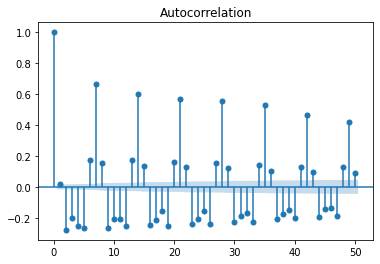

In [973]:
plot_acf(varmax_dataset['new_deaths'], lags=50);

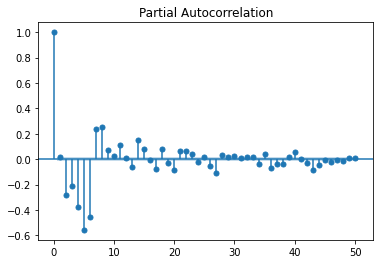

In [962]:
plot_pacf(varmax_dataset['new_deaths'], lags=50);

In [ ]:
mod = sm.tsa.VARMAX(np.asarray(varmax_dataset[endogeneous_variables]), np.asarray(varmax_dataset[exogeneous_variables]), order=(1, 0))

In [925]:
res = mod.fit(maxiter=100, disp=False)
res.summary()

/home/ion/.local/lib/python3.9/site-packages/scipy/linalg/_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.55979e-23): result may not be accurate.
  x = solve(lhs, q.flatten())
/home/ion/.local/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                             Statespace Model Results                                             
==================================================================================================================
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9']   No. Observations:                15061
Model:                                                            VARX(1)   Log Likelihood            -1099341.799
                                                              + intercept   AIC                        2199043.599
Date:                                                    Sun, 19 Dec 2021   BIC                        2200415.174
Time:                                                            21:09:40   HQIC                       2199498.578
Sample:                                                                 0                                         
                                                                  - 15061                                         
Covariance Type:                                                      opg                                         
=========================================================================================================================================================================================================================================
Ljung-Box (L1) (Q):           424.85, 3.29, 98.55, 37.46, 14.26, 1.45, 0.46, 3.59, 0.06   Jarque-Bera (JB):   35624338.37, 3839046.75, 13550084940.93, 1127279.16, 131000122.94, 77469085119.41, 11674930.39, 71714724232.46, 10356035.36
Prob(Q):                           0.00, 0.07, 0.00, 0.00, 0.00, 0.23, 0.50, 0.06, 0.80   Prob(JB):                                                                                  0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 180.44, 74.65, 143.01, 8.49, 2.33, 600.07, 52.17, 1603.02, 0.87   Skew:                                                                               4.31, 2.96, 50.21, 1.50, -8.30, -97.56, 1.12, -93.67, -3.82
Prob(H) (two-sided):               0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:                                                             241.10, 80.99, 4648.67, 45.28, 459.59, 11112.03, 139.38, 10691.49, 131.24
                           Results for equation y1                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9555        nan        nan        nan         nan         nan
L1.y1         -0.4555      0.000   -938.427      0.000      -0.456      -0.455
L1.y2         14.6768        nan        nan        nan         nan         nan
L1.y3          5.5553        nan        nan        nan         nan         nan
L1.y4          0.0028      0.000      9.320      0.000       0.002       0.003
L1.y5      -6873.4516   5.22e-10  -1.32e+13      0.000   -6873.452   -6873.452
L1.y6         -0.0004      0.000     -2.248      0.025      -0.001   -5.39e-05
L1.y7          0.0014      0.000      3.691      0.000       0.001       0.002
L1.y8          0.0120      0.000     24.360      0.000       0.011       0.013
L1.y9          1.9699   6.06e-09   3.25e+08      0.000       1.970       1.970
beta.x1    -7.466e-06      0.000     -0.067      0.947      -0.000       0.000
beta.x2       -1.4235        nan        nan        nan         nan         nan
beta.x3        4.5946    4.2e-09   1.09e+09      0.000       4.595       4.595
beta.x4      695.4723   2.91e-11   2.39e+13      0.000     695.472     695.472
beta.x5     2.187e+04   1.37e-12    1.6e+16      0.000    2.19e+04    2.19e+04
                           Results for equation y2                            
====================================================

In [954]:
prediction = res.get_prediction()
prediction_mean = prediction.predicted_mean
prediction_mean = pd.DataFrame(prediction_mean, columns=endogeneous_variables)

/home/ion/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1766: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


### ACF and PACF

In [ ]:
# pacf 


Europe


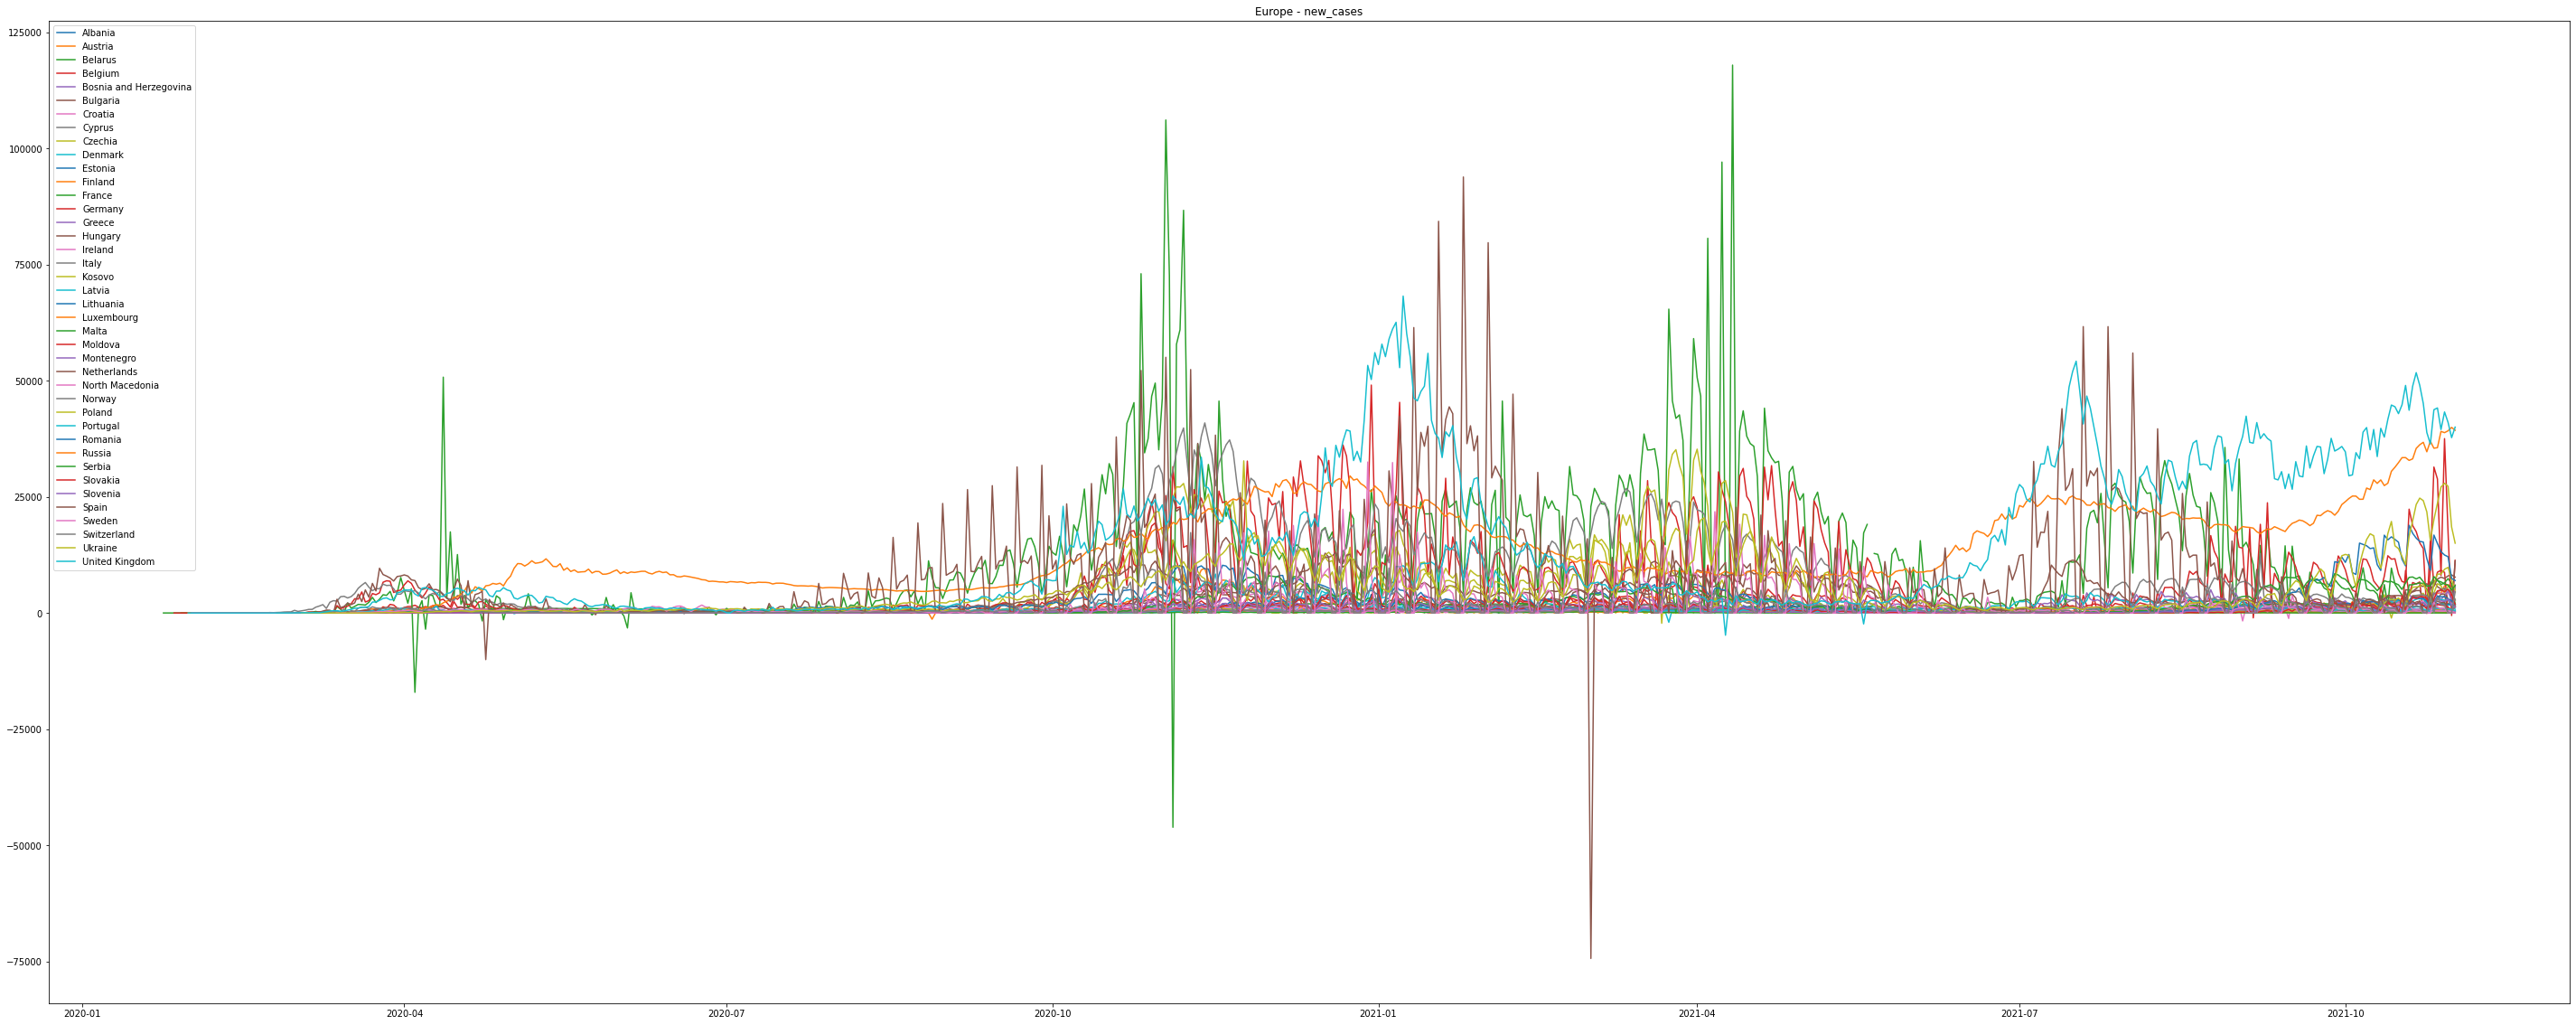

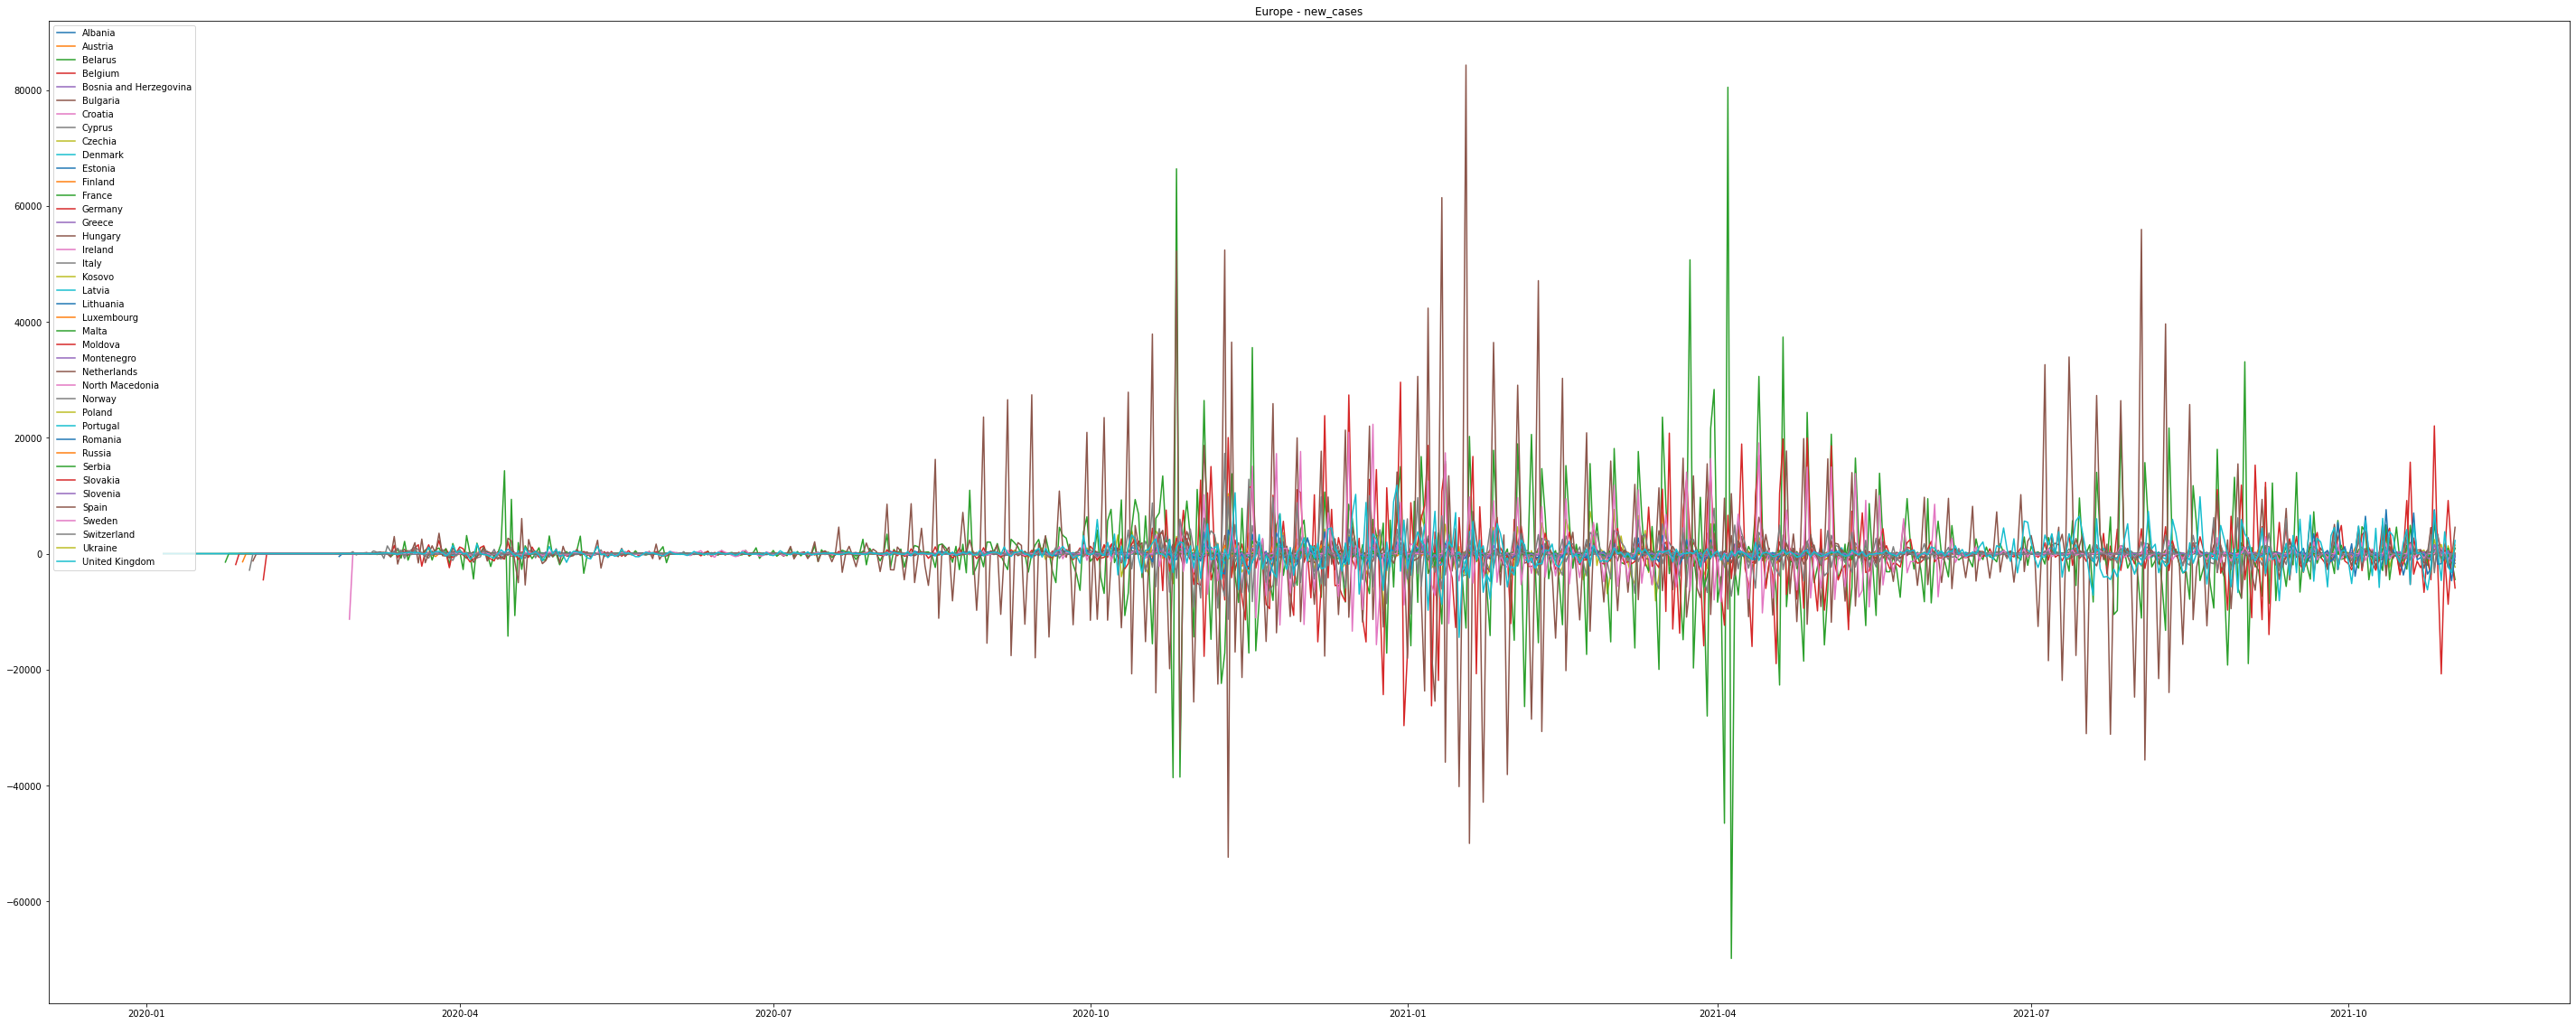

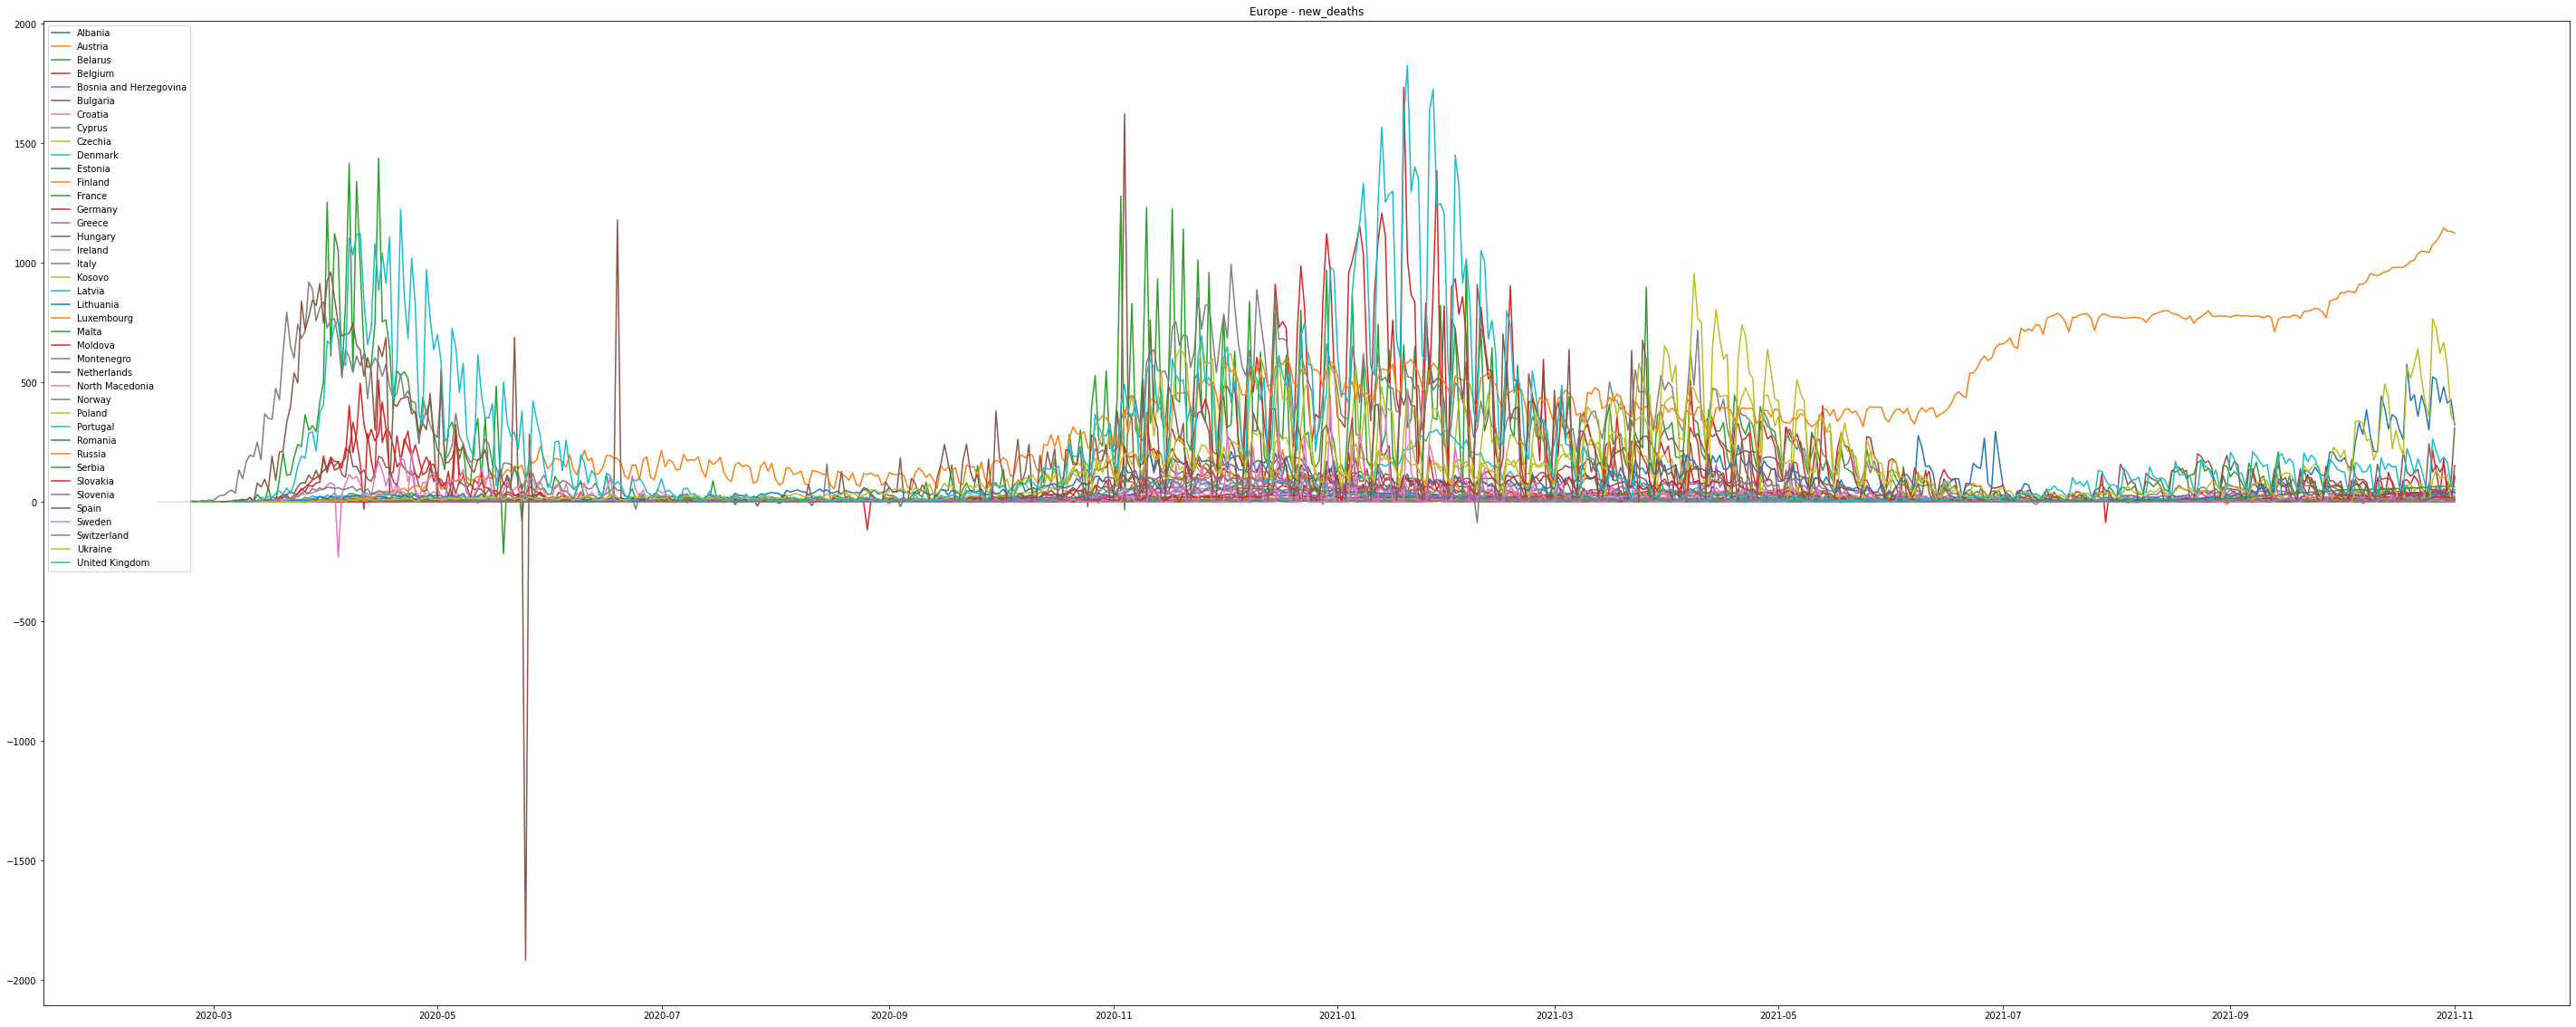

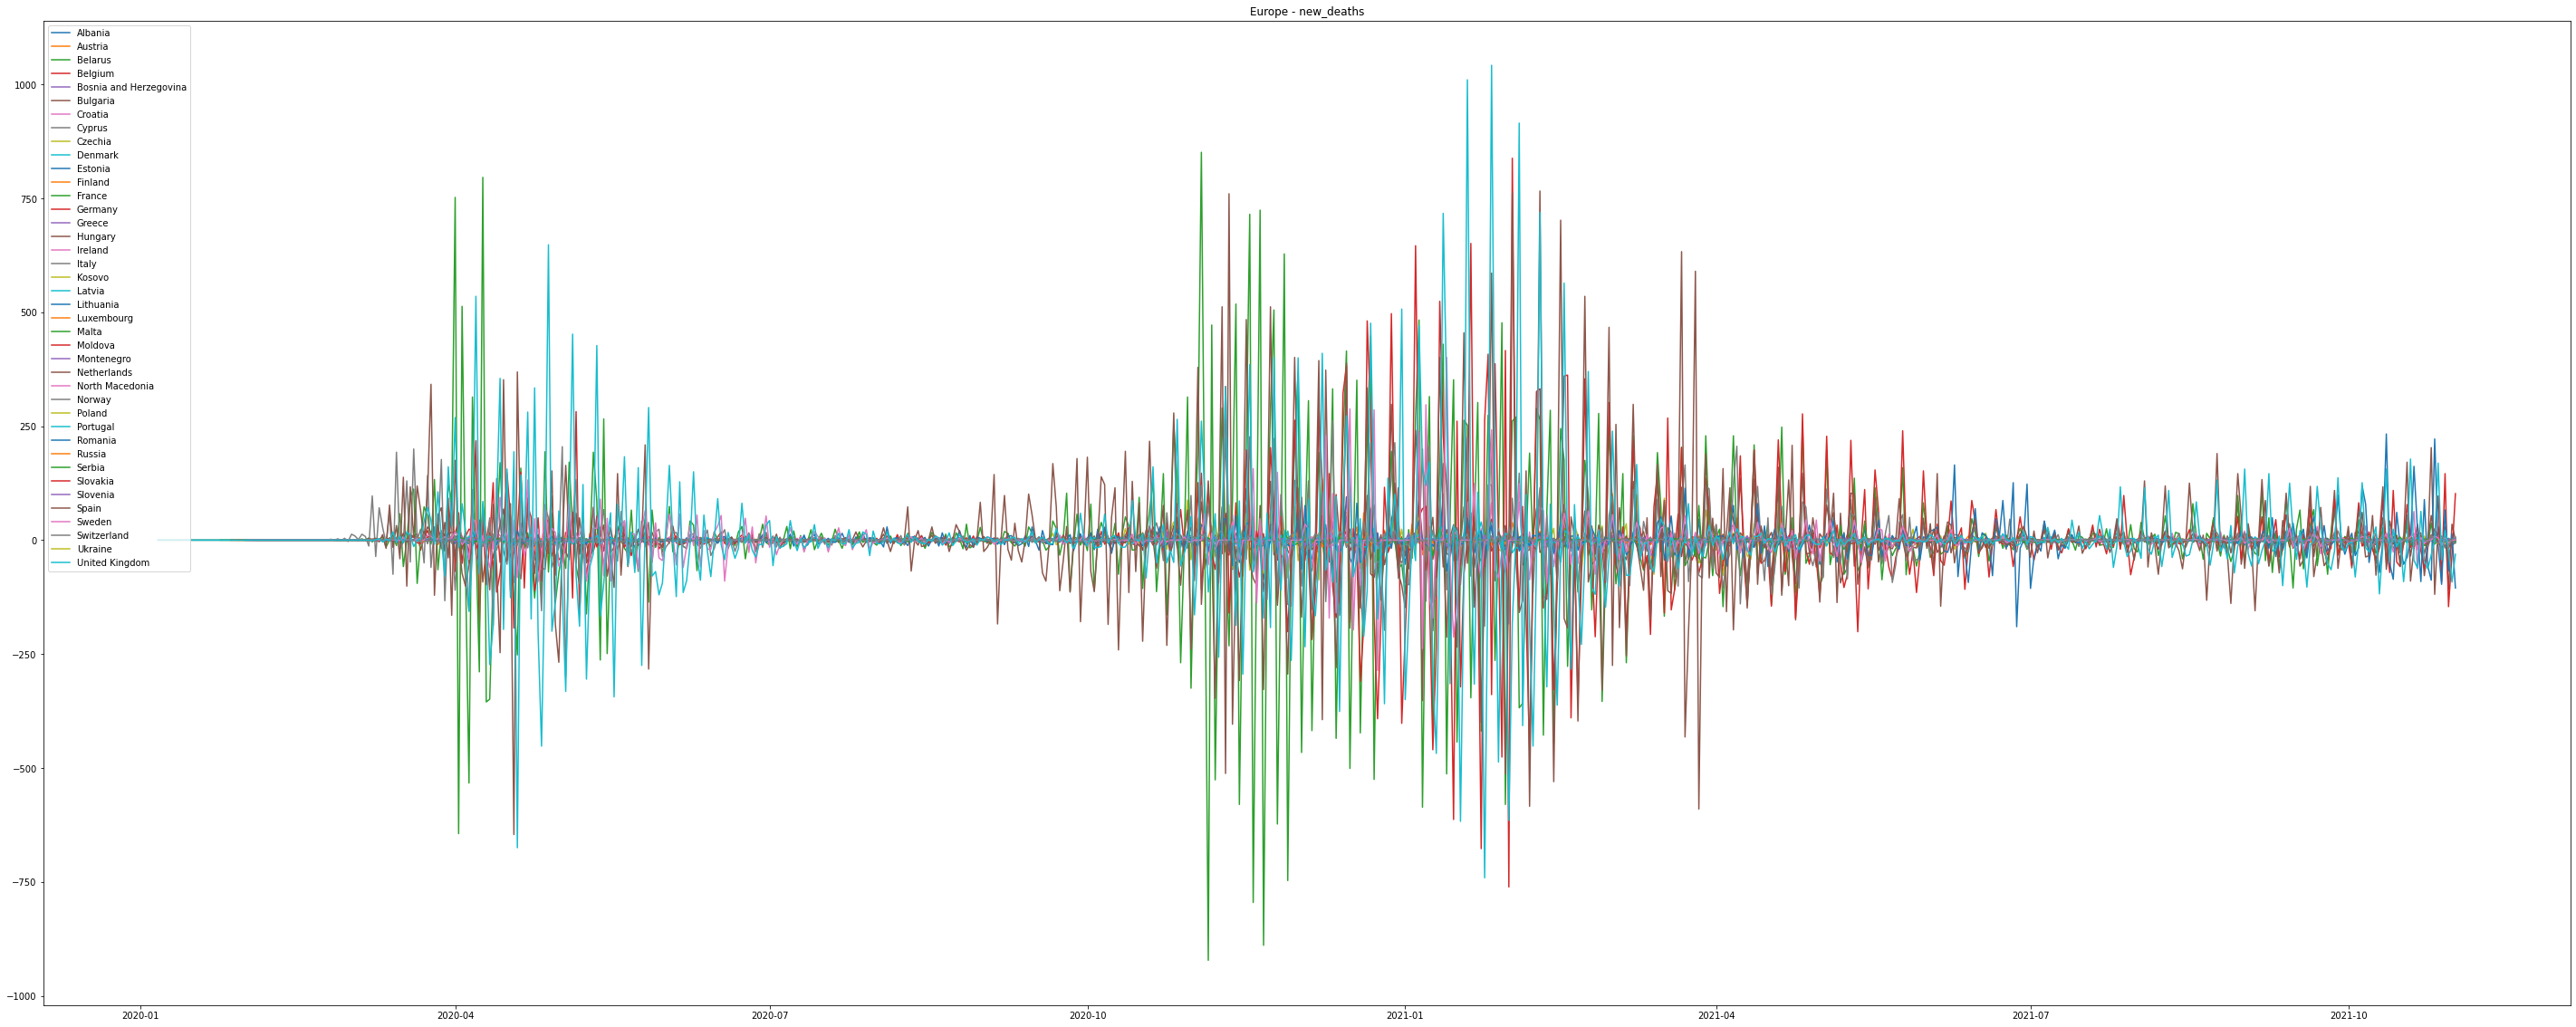

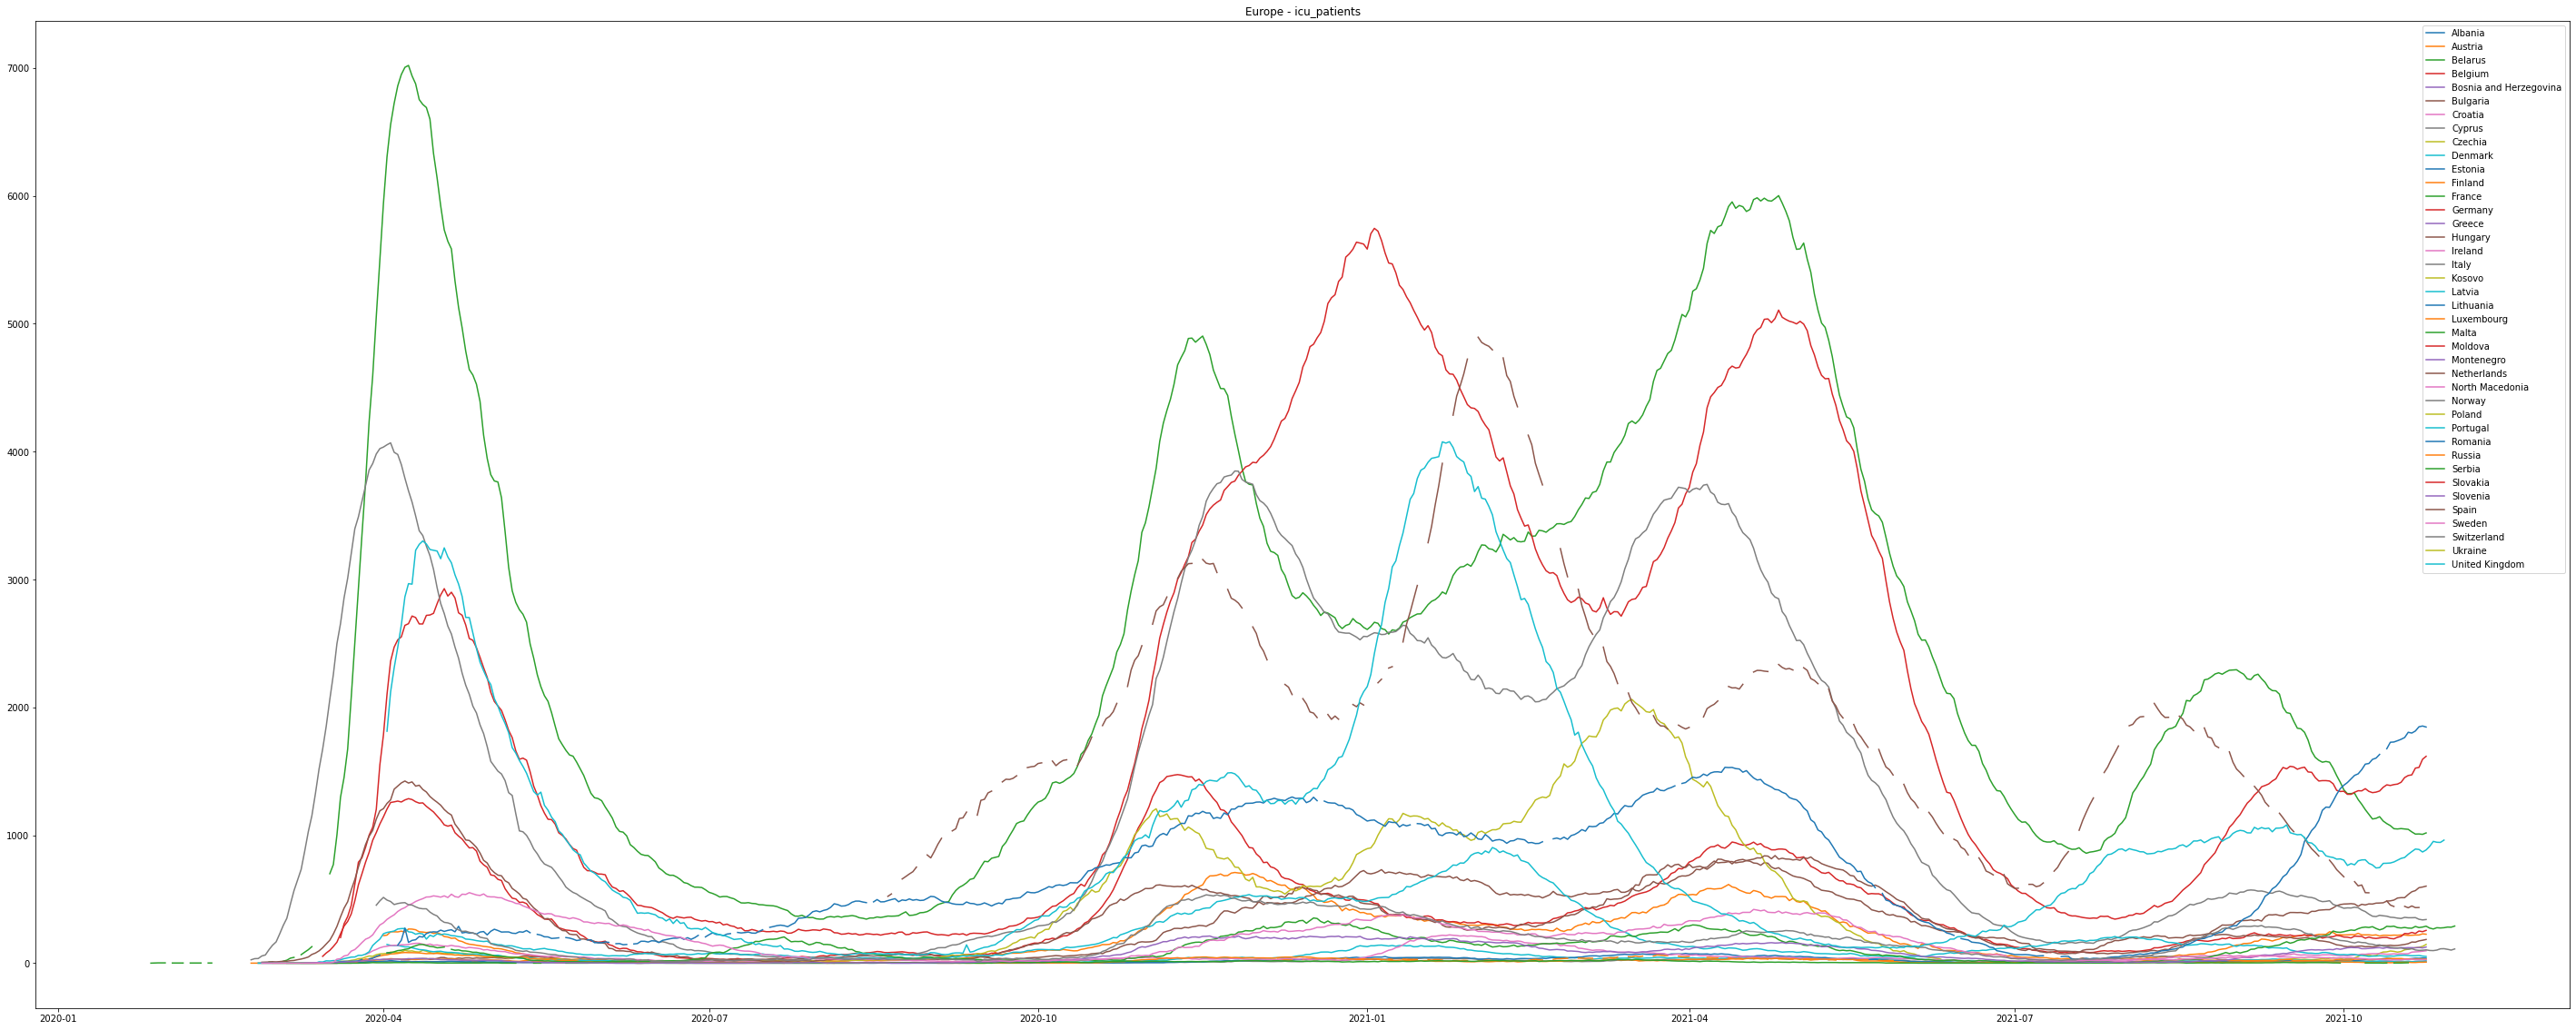

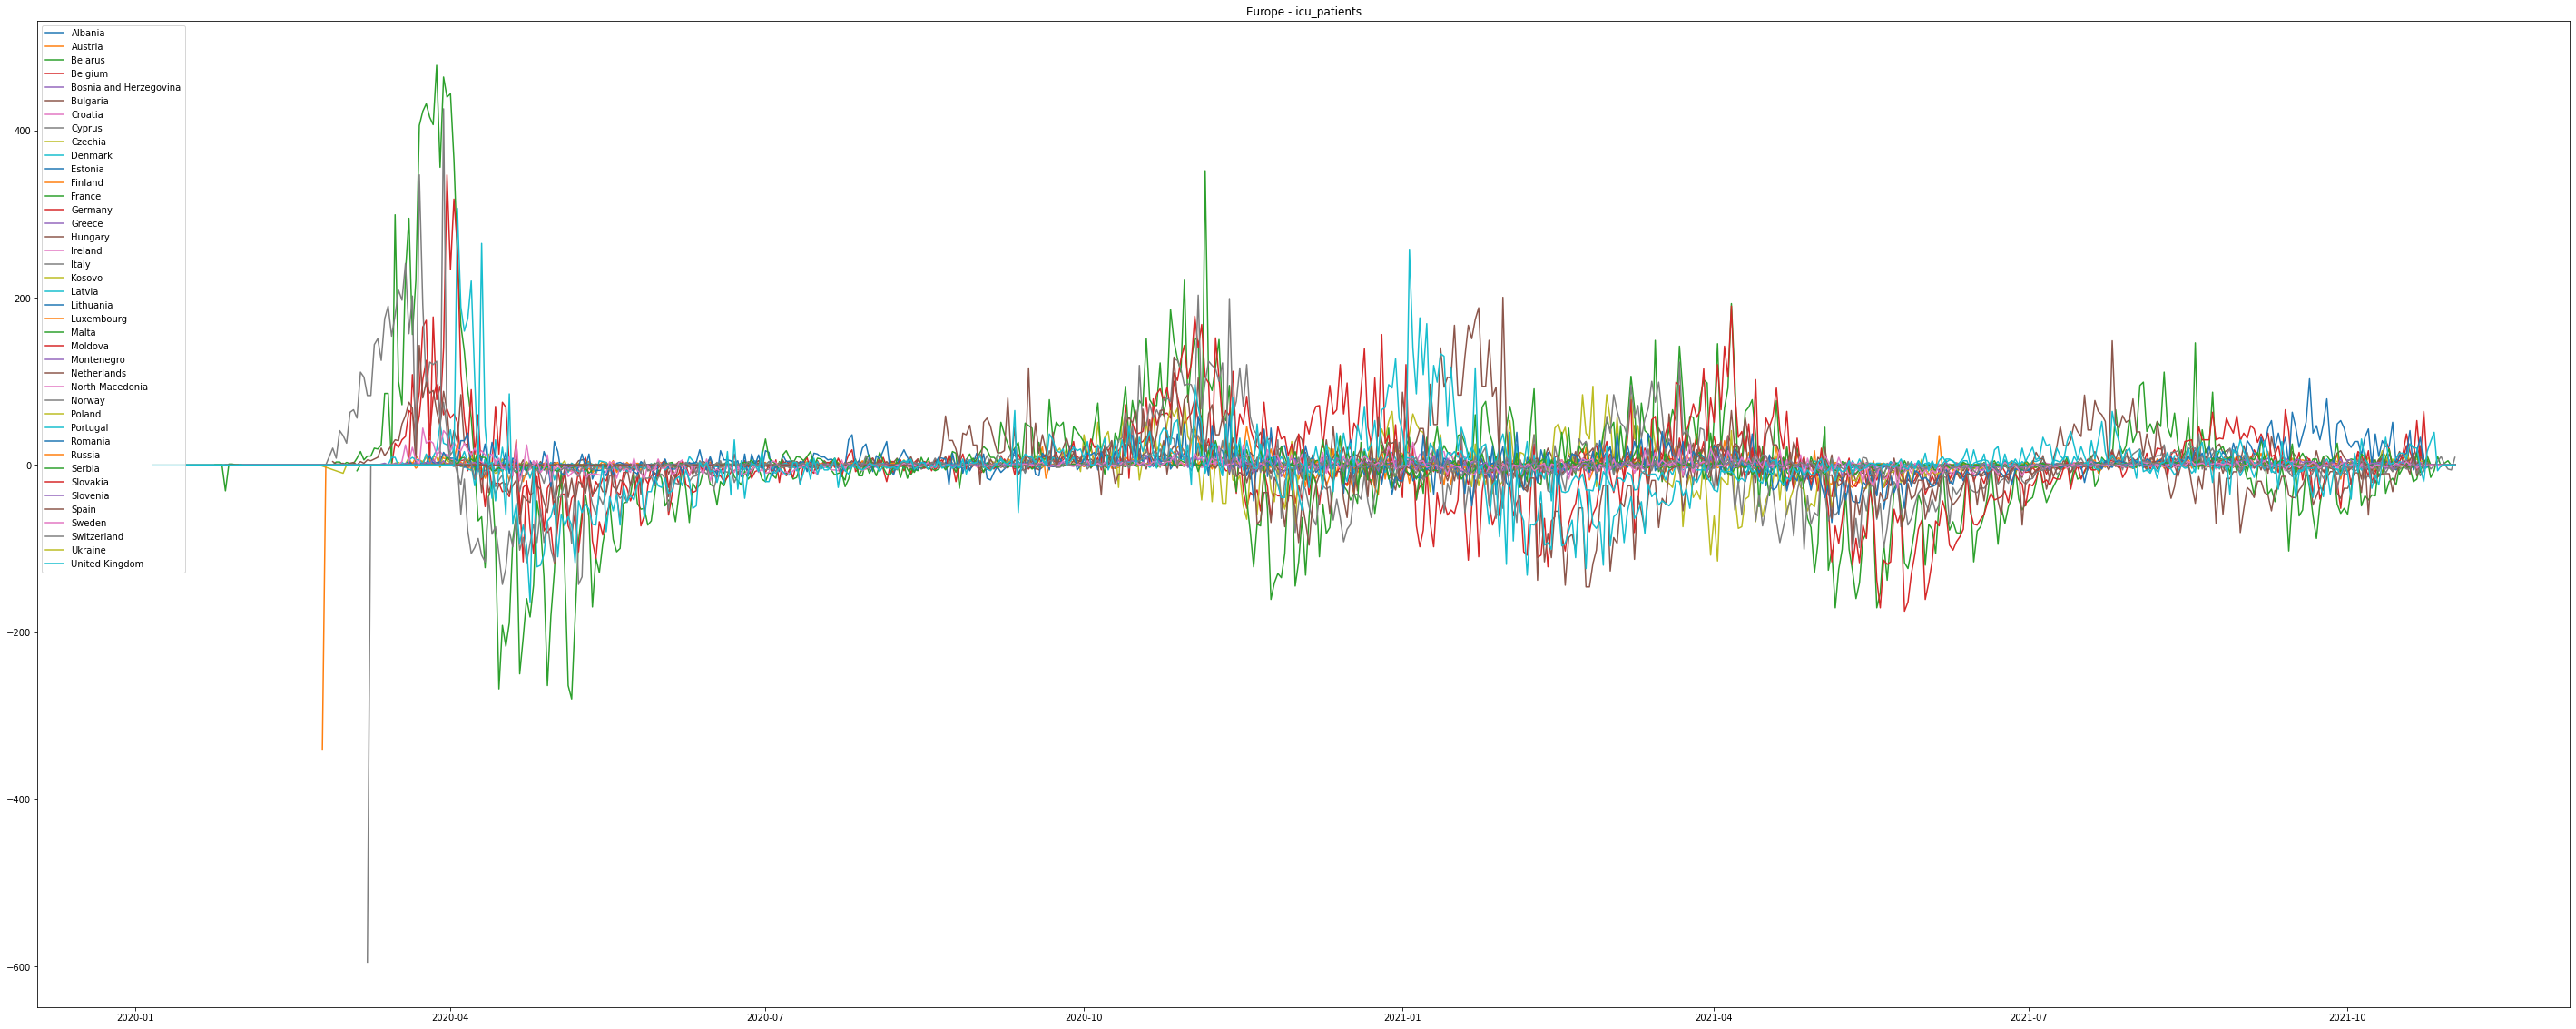

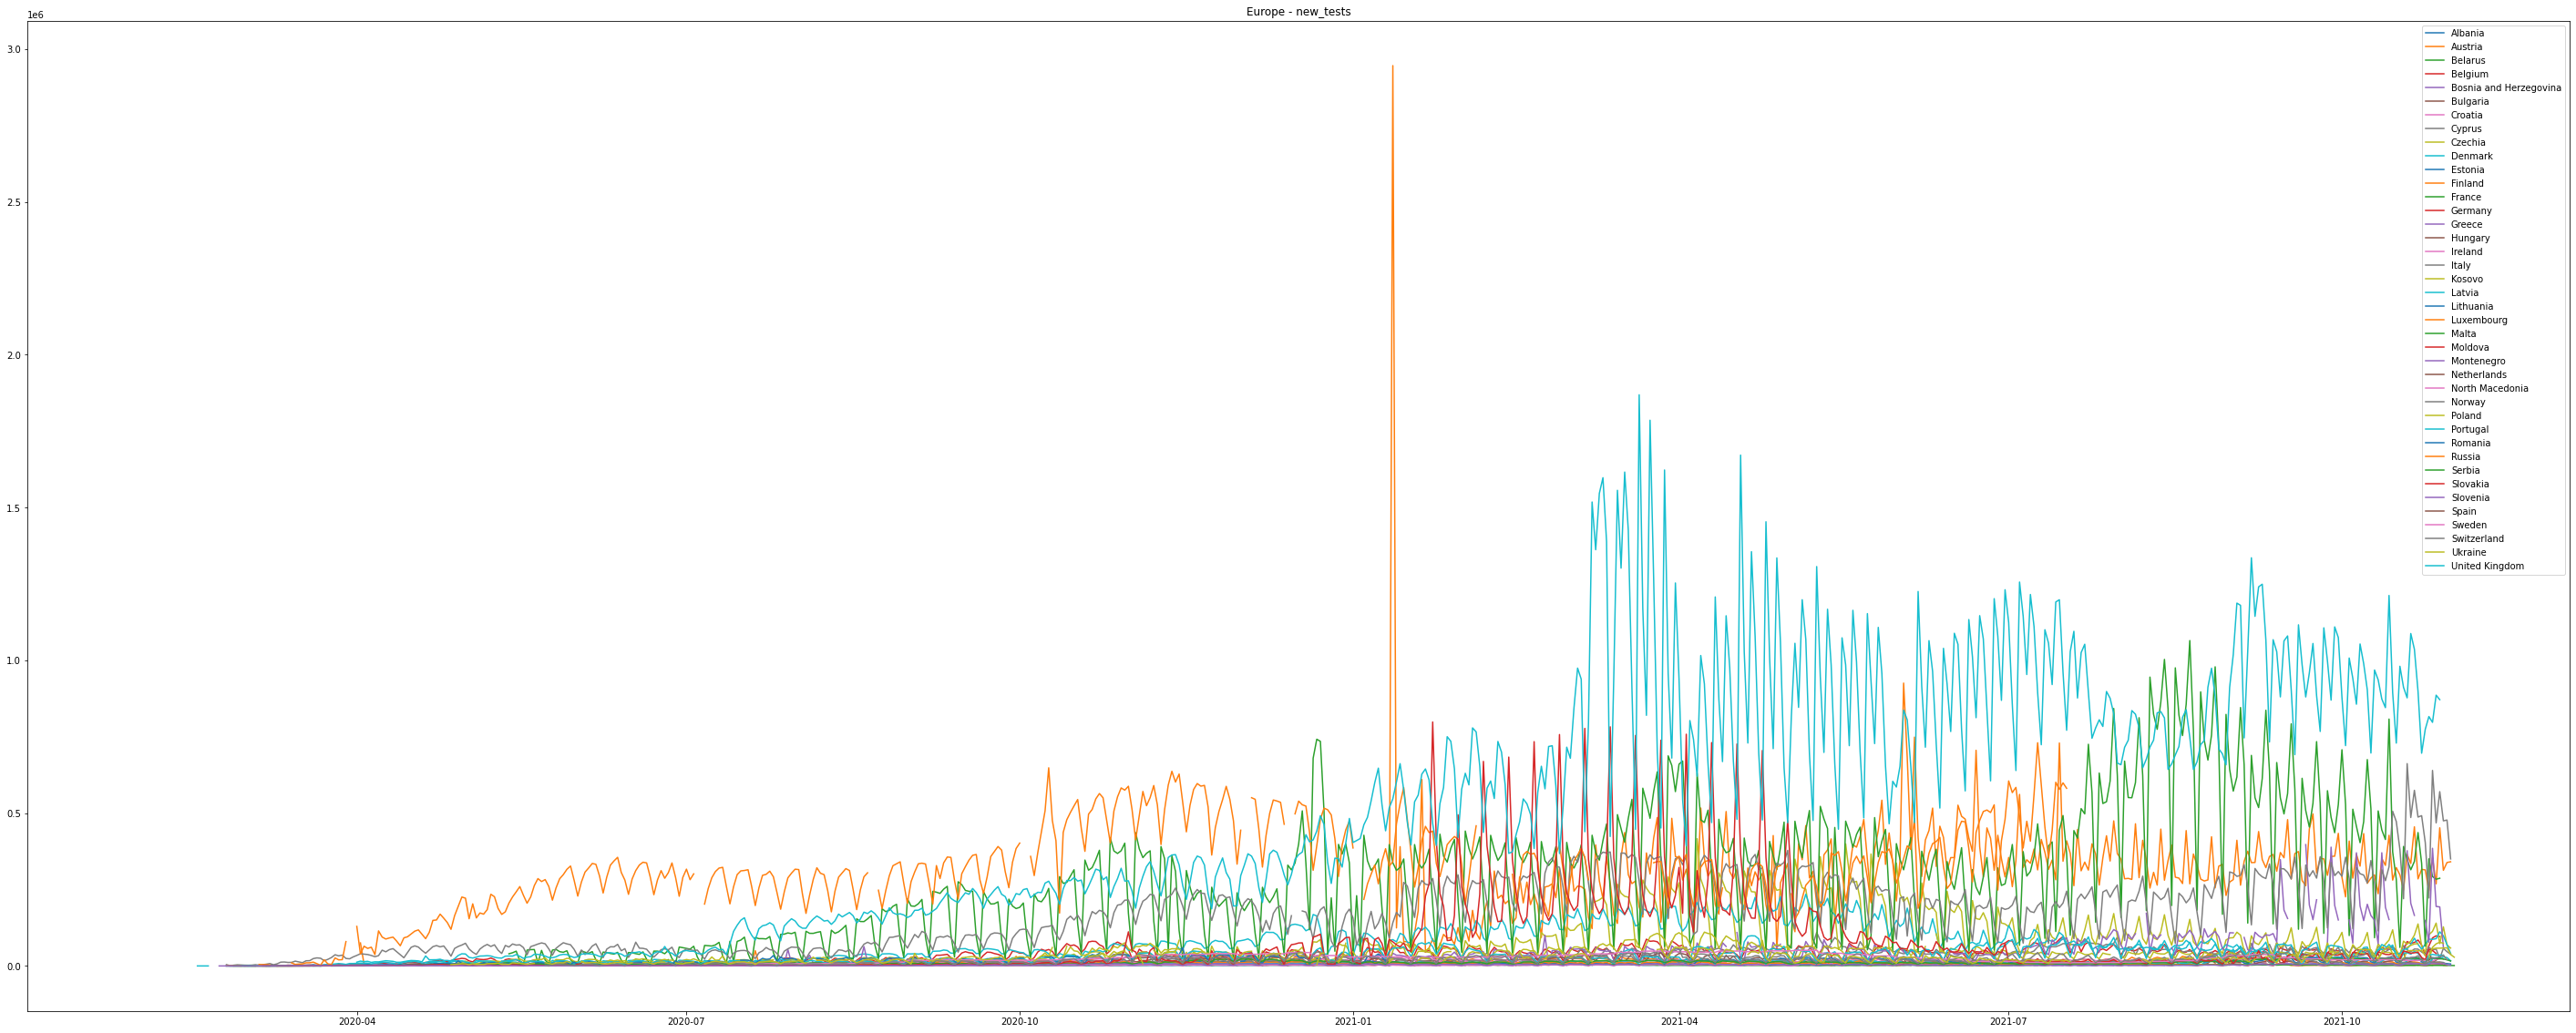

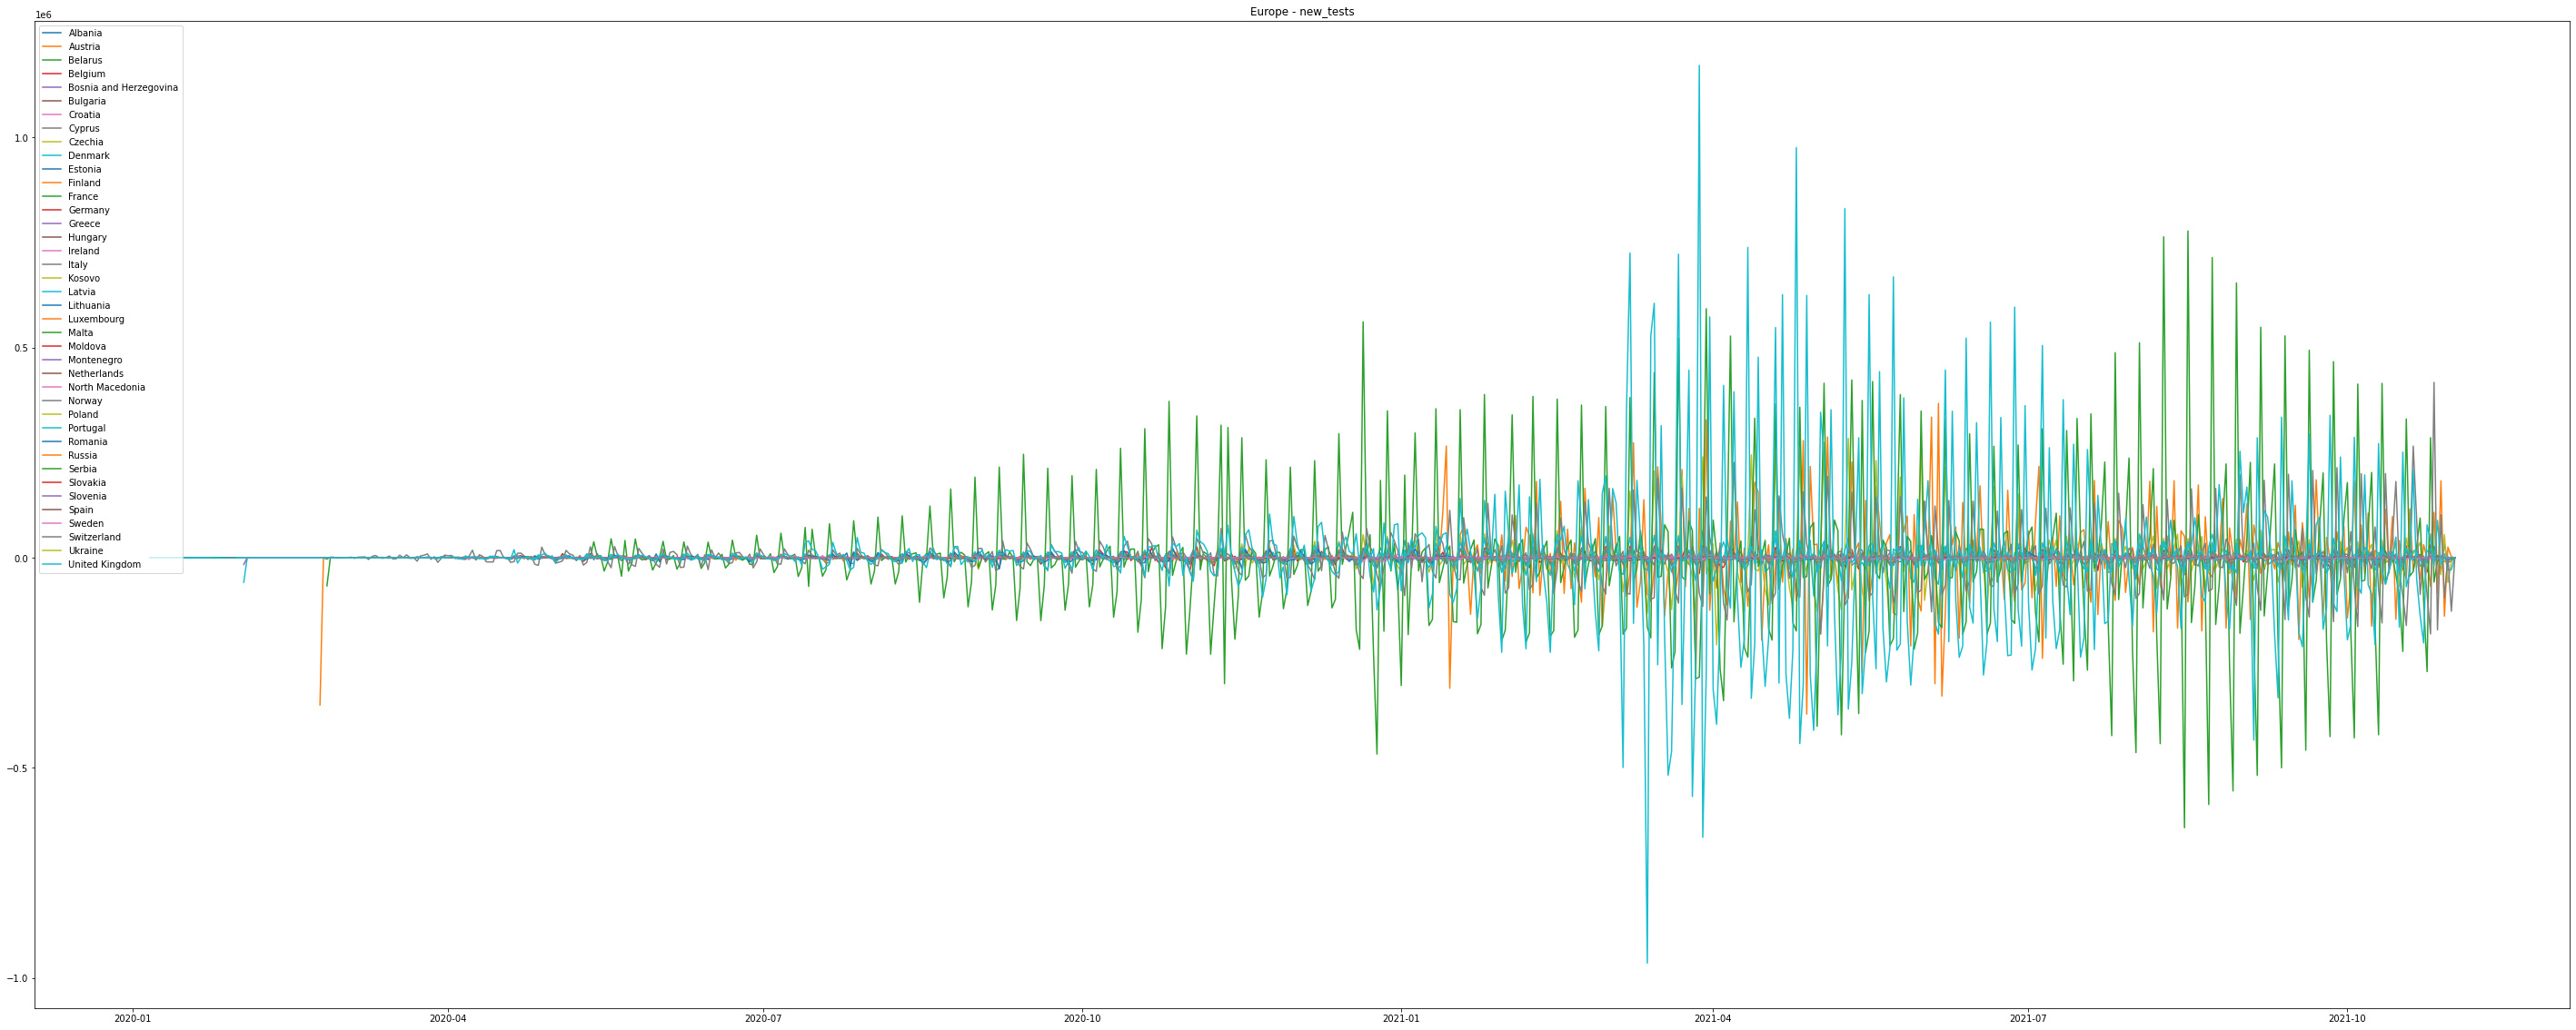

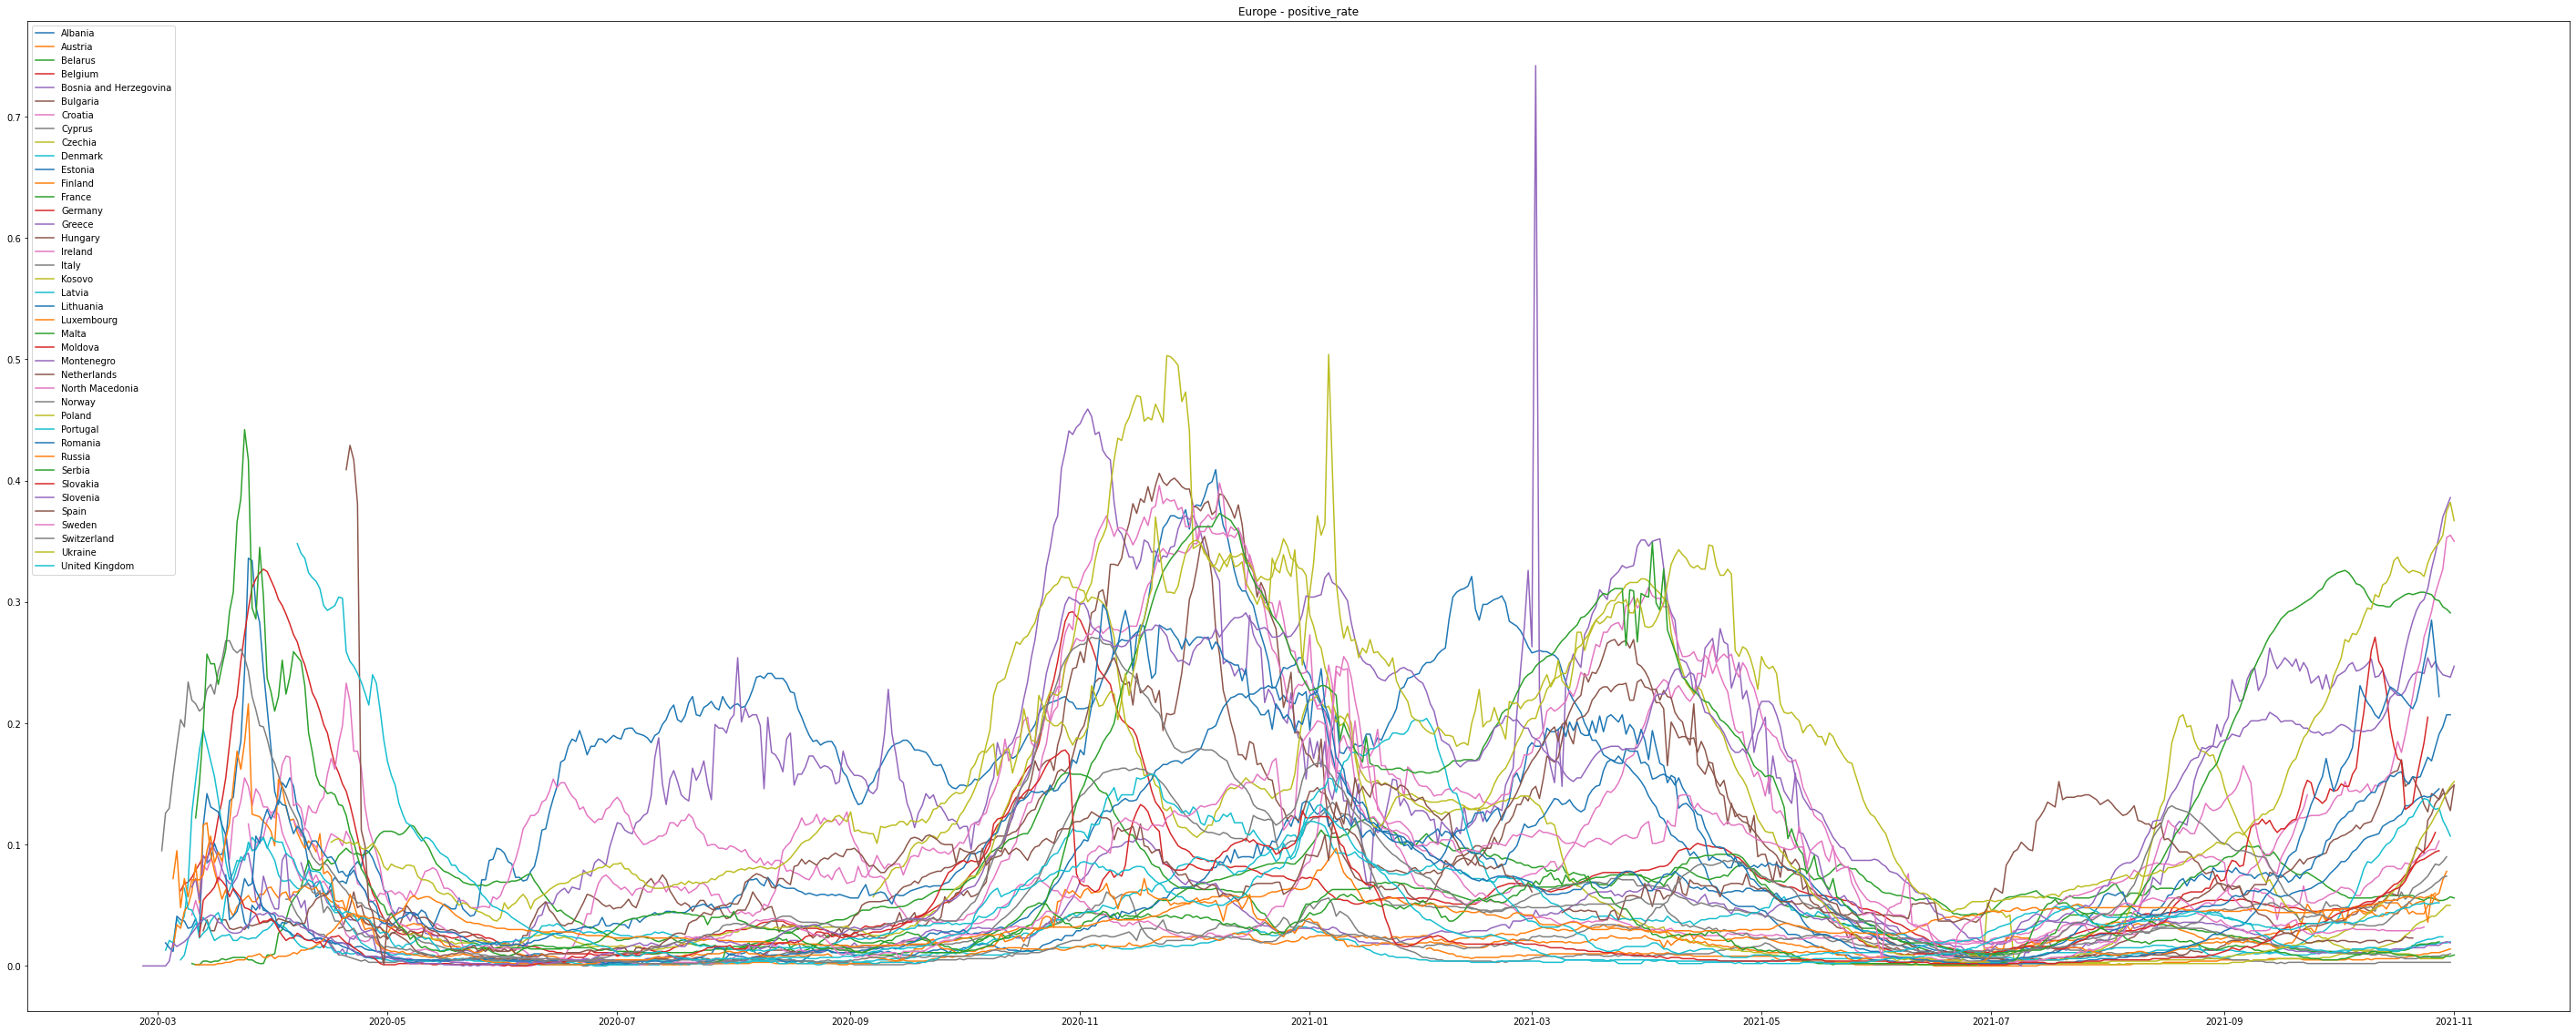

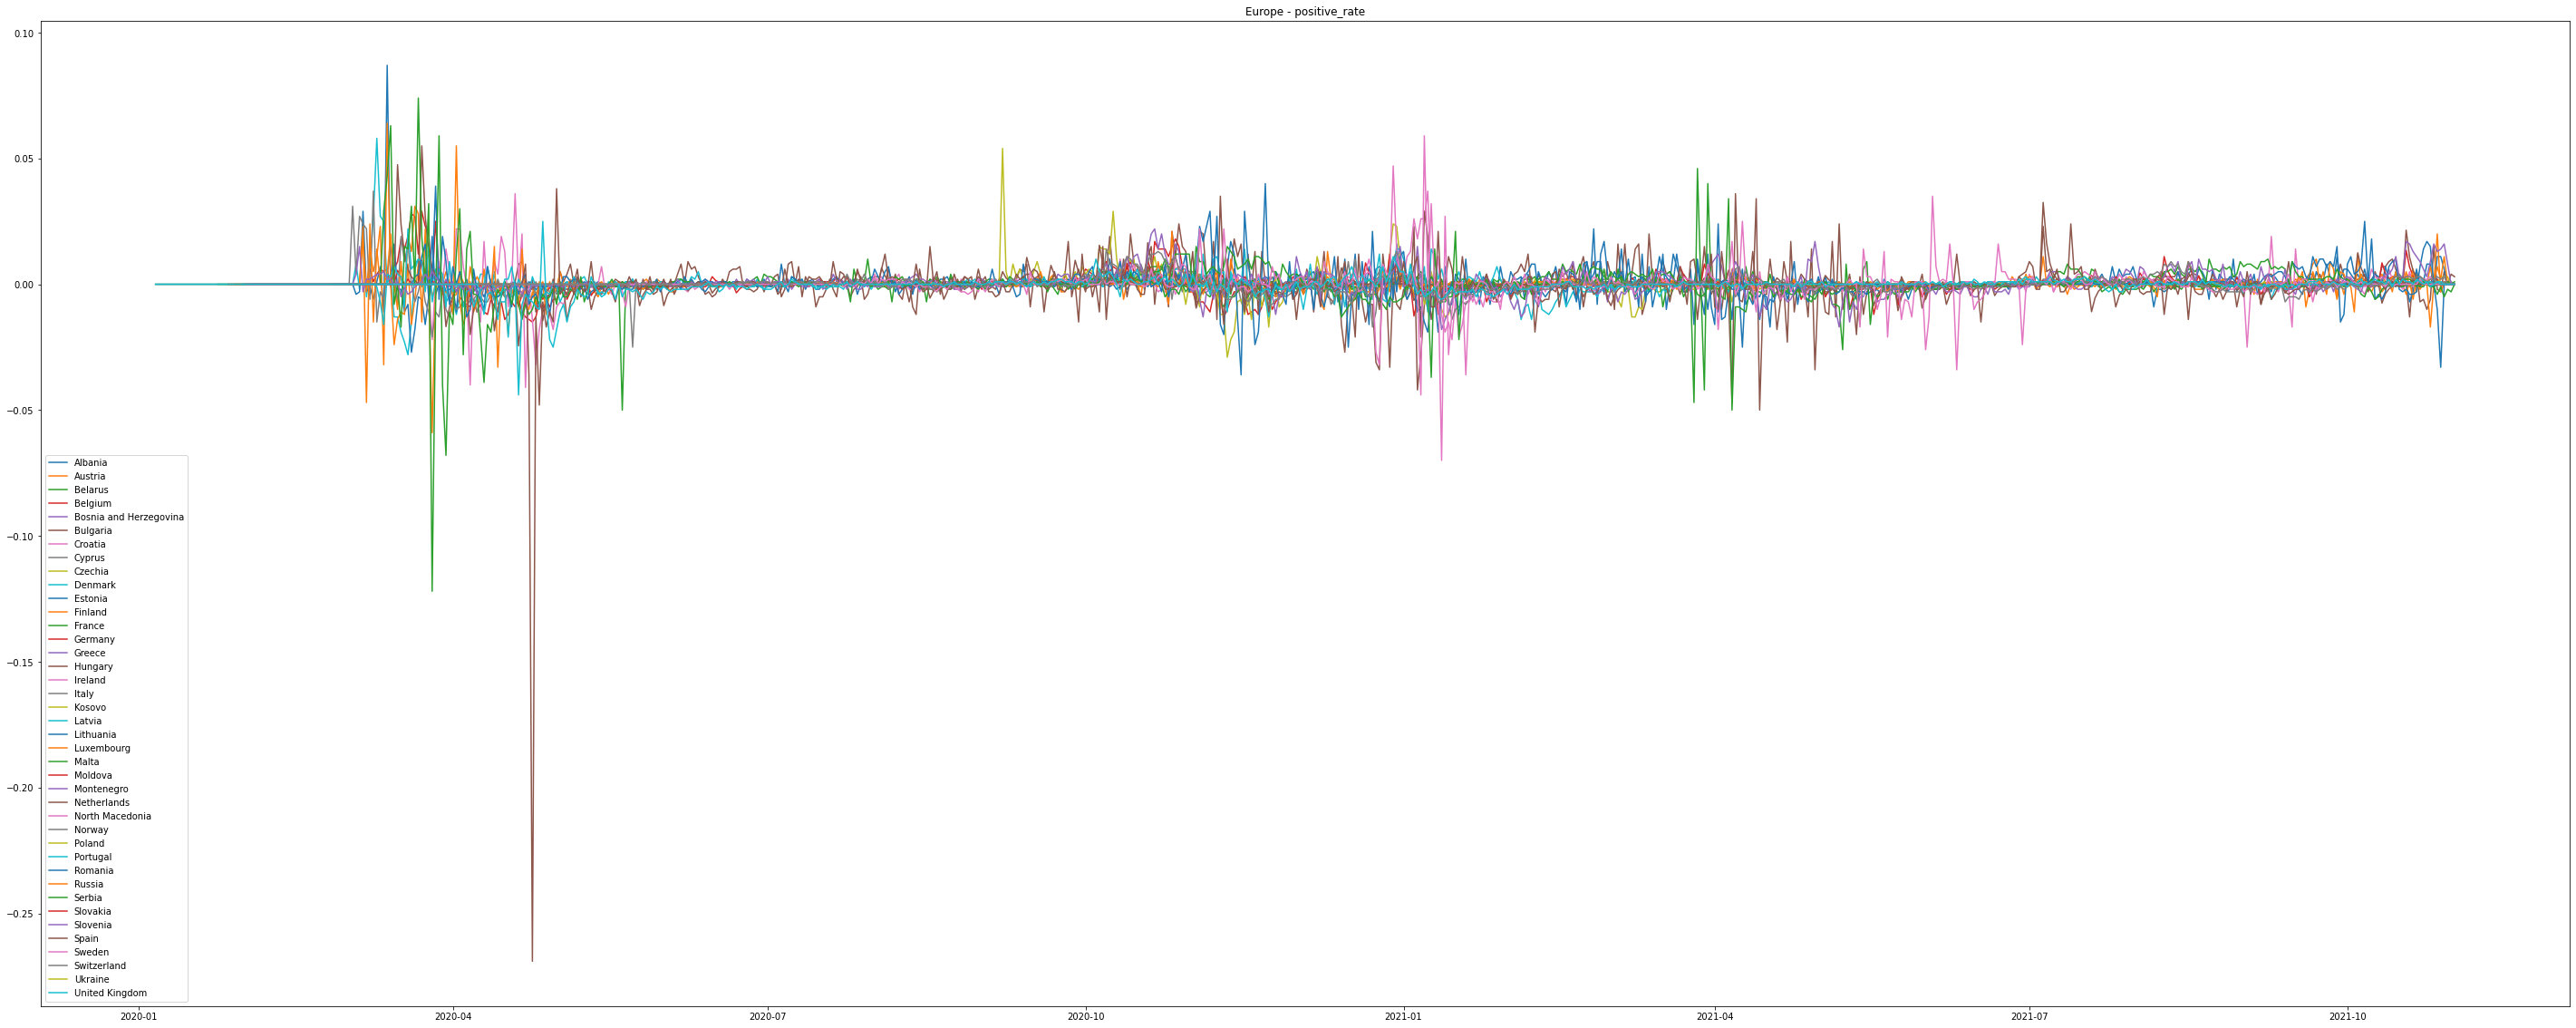

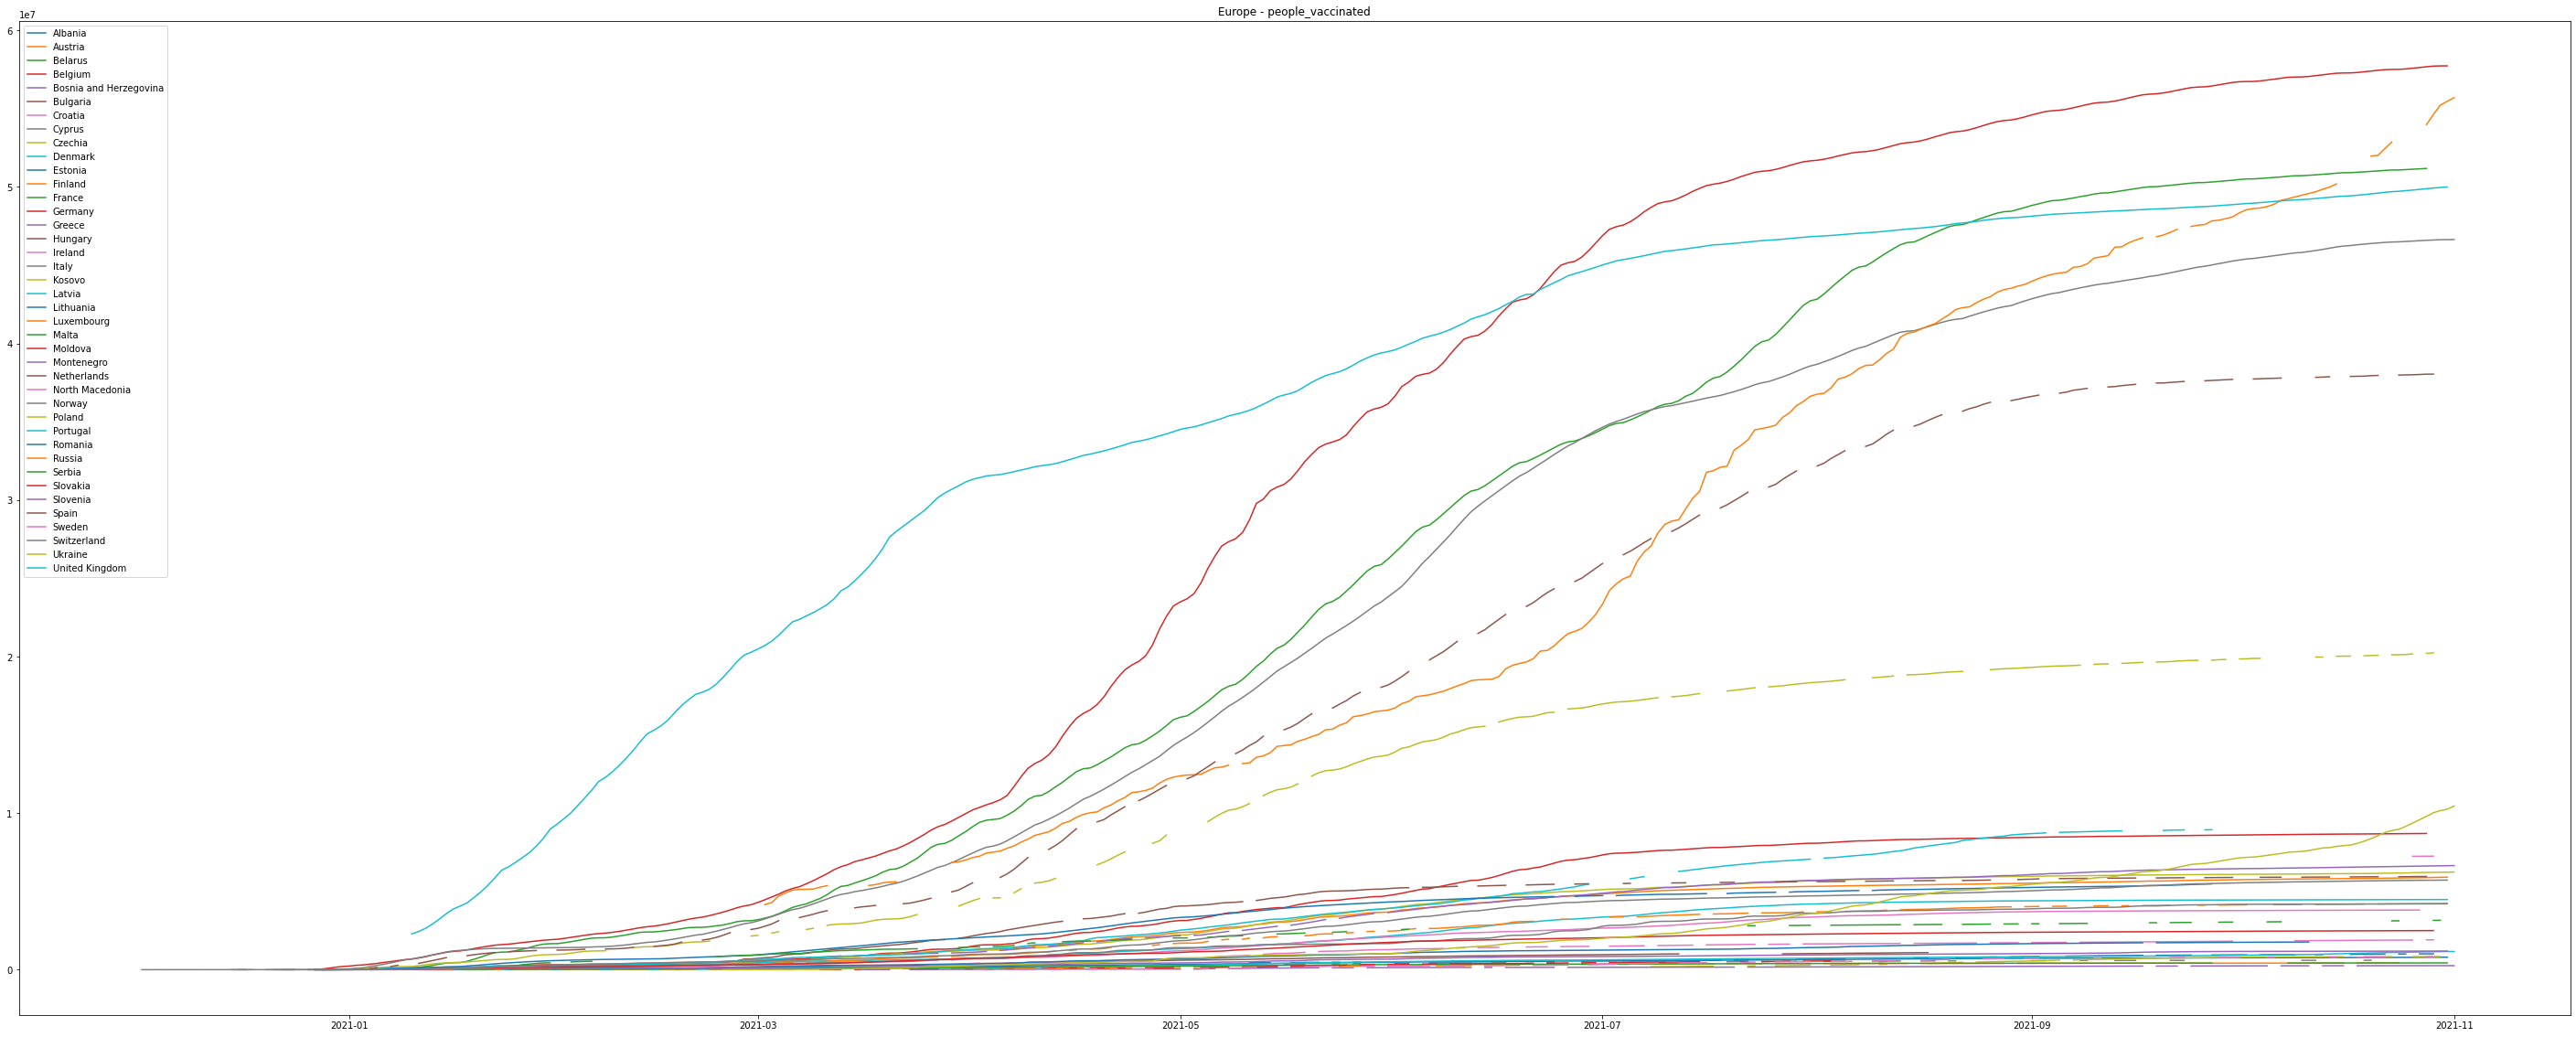

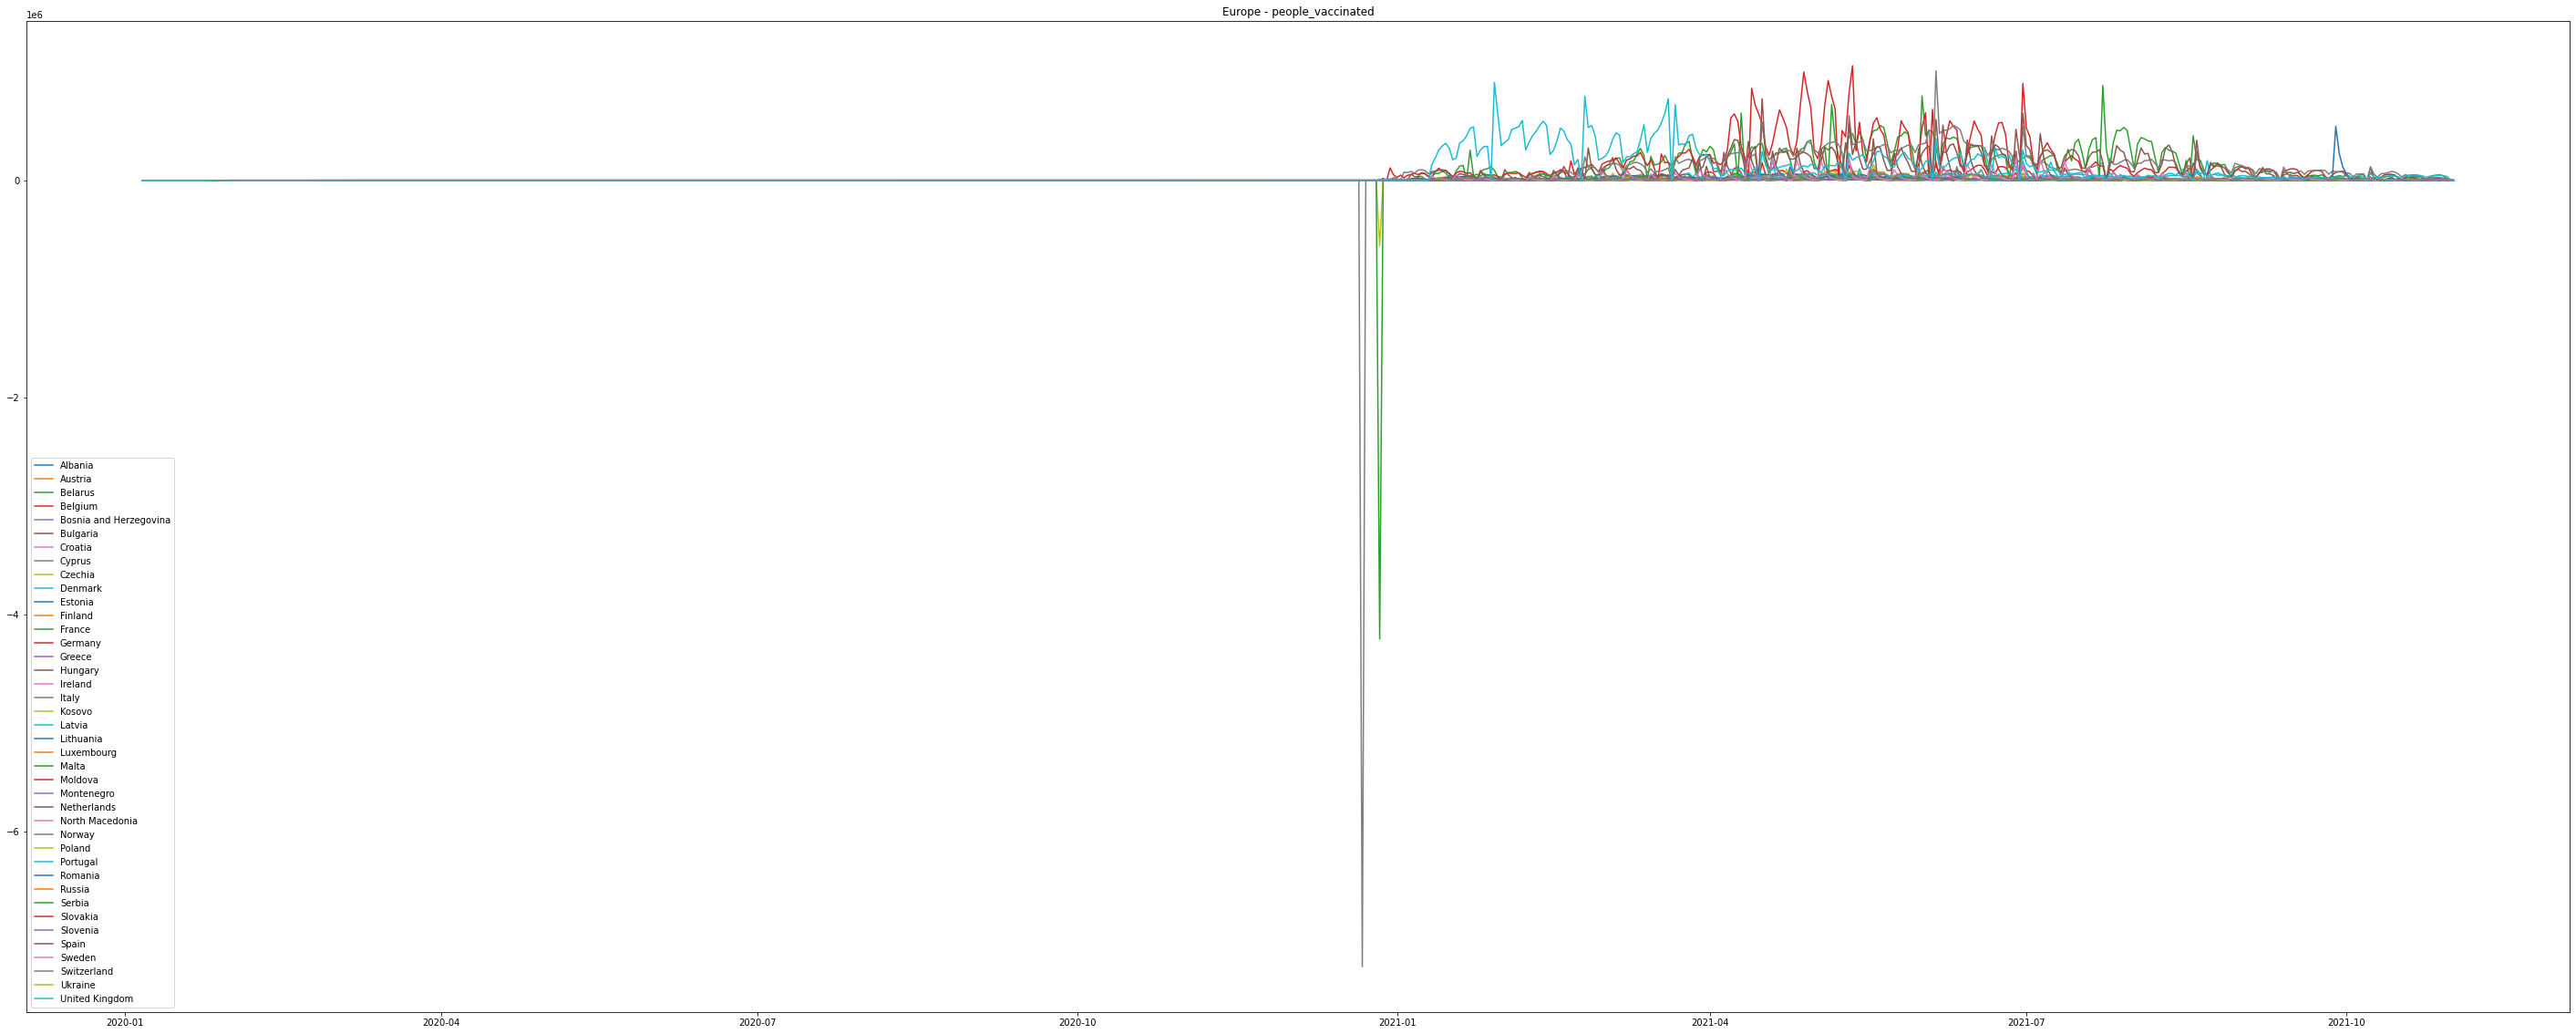

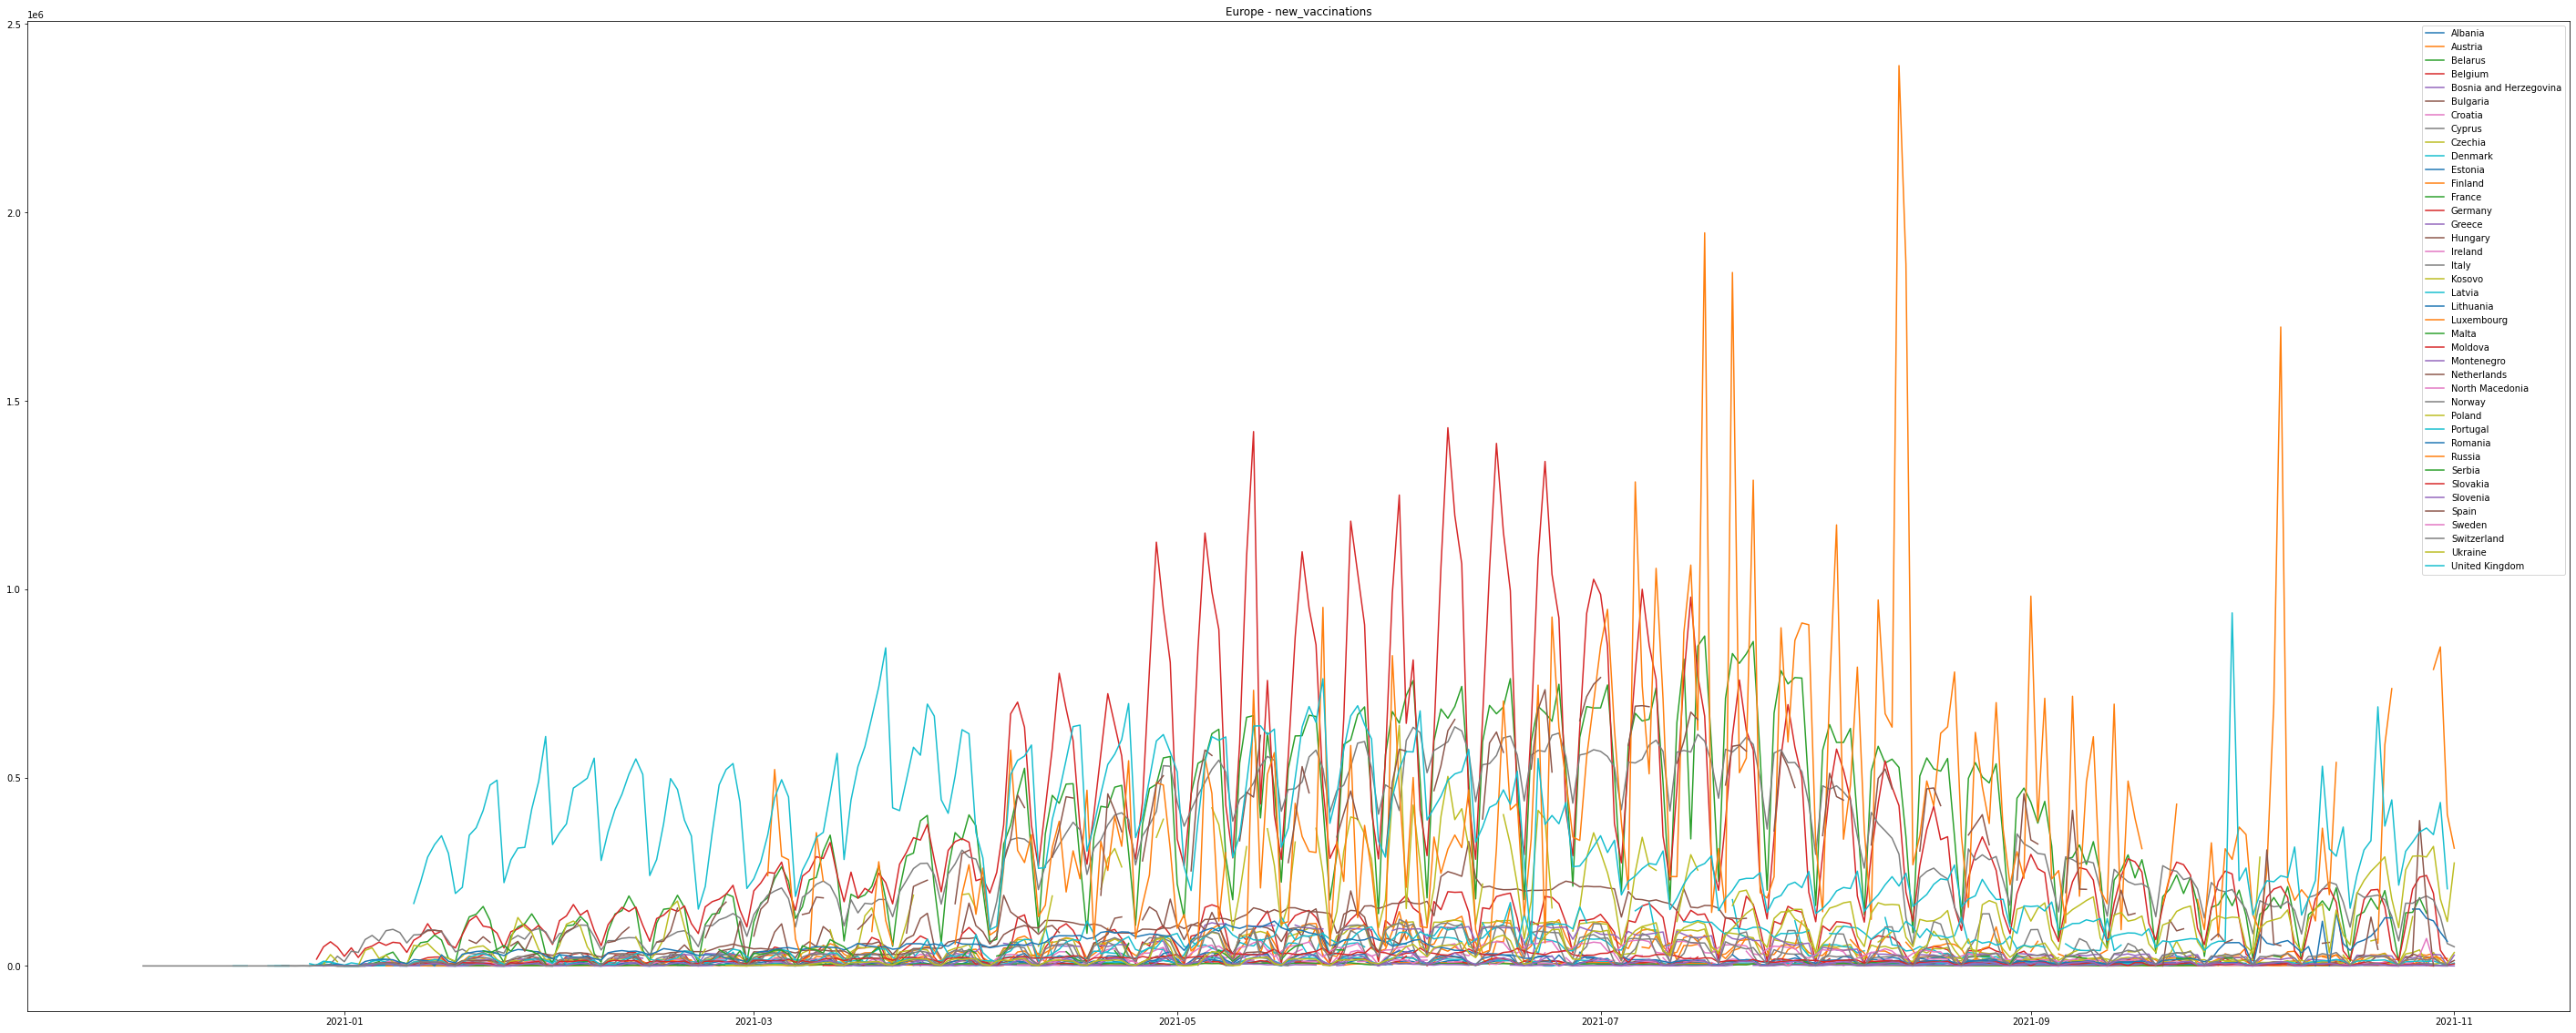

KeyboardInterrupt: 

In [957]:
plot_vars_per_country(dataset, varmax_dataset)